# Robust Stochastic Block Model Estimation via Subgraph Search

Fold the `Code` cell and run everything in it.

Then, define and run your experiments in the `Experiments` cell.

If running locally, please use Python 3.10. There is a `requirements.txt` available.

## Code

### Imports

In [ ]:
# Run this if on Colab: it does not include this package by default.
!pip install scikit-network

In [ ]:
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
import networkx as nx
from sknetwork.topology import is_connected
from sklearn.cluster import KMeans, SpectralClustering
from scipy import linalg, stats, optimize
from itertools import permutations, product
from tqdm.notebook import tqdm
import pickle

from typing import Union, Optional, List, Callable, Any, Dict, Type
from numpy.typing import ArrayLike
from dataclasses import dataclass, field, asdict
from abc import ABC, abstractmethod
from copy import deepcopy
from functools import partial, reduce

In [ ]:
# Float formatting
np.set_printoptions(precision=3)

### Graph classes

In [ ]:
@dataclass
class Graph:
  n: int
  K: int
  A: np.ndarray
  Z: np.ndarray
  z: np.ndarray = field(init=False)
  nodes_in_community: List[np.ndarray] = field(init=False)


  def __post_init__(self):
    self.z = self._one_hot_decode()
    self.nodes_in_community = self._compute_nodes_in_community()


  def _one_hot_decode(self):
    return np.argmax(self.Z, axis=1)


  def _compute_nodes_in_community(self) -> List[np.ndarray]:
    """Returns a list `communities`, such that communities[k] contains the
    indices of nodes in community k.
    """

    communities = [np.where(self.z == k)[0] for k in range(self.K)]
    return communities


  def neighbors(self, node):
    """Returns the indices of neighbors of node."""
    return np.where(self.A[node,:]==1)[0]


  def degree(self, node):
    """Returns the degree of a node."""
    return np.sum(self.A[node,:])


  def subgraph(self, nodes: Union[List, np.ndarray]):
    """Returns Graph corresponding to nodes given. Assumes the number
    of communities remains the same.
    """

    # Convert to numpy if necessary
    if not isinstance(nodes, np.ndarray):
      nodes = np.array(nodes)

    return Graph(
        n=nodes.shape[0],
        K=self.K,
        A=self.subgraph_adjacency_matrix(nodes),
        Z=self.Z[nodes,:],
    )


  def subgraph_adjacency_matrix(self, nodes: ArrayLike) -> np.ndarray:
    """Returns the adjacency matrix of the subgraph induced by 'nodes'.

    Args:
      nodes: A list with the indices of nodes to include in the subgraph.

    Returns:
      The adjacency matrix of the subgraph.
    """

    subgraph = self.A[np.ix_(nodes, nodes)]
    return subgraph


  @staticmethod
  def load_from_edge_csv(filepath: str, K: int):
    """Given a CSV file with columns 'source' and 'target' nodes, we load it
    into an adjacency matrix.
    """

    df = pd.read_csv(filepath)
    source_nodes = df['source'].to_numpy()
    target_nodes = df['target'].to_numpy()

    # Find the largest node idx to set the size of the adjacency matrix
    n = int(np.max([np.max(source_nodes), np.max(target_nodes)])) + 1

    A = np.zeros((n, n))

    # We transform directed graphs into undirected ones
    for i in range(len(source_nodes)):
      A[source_nodes[i], target_nodes[i]] = 1
      A[target_nodes[i], source_nodes[i]] = 1

    return Graph(
        n=n,
        K=K,
        A=A,
        Z=np.zeros((n, K)),
    )


  def remove_small_components(self, component_size=5):
    """Removes isolated nodes and nodes belonging to small components."""

    # Create networkx version
    G_nx = nx.from_numpy_array(self.A)

    nodes_small_components = []

    for component in list(nx.connected_components(G_nx)):
      if len(component) < component_size:
        for node in component:
          nodes_small_components.append(node)

    nodes_to_keep_idx = [i for i in range(self.n)
                         if i not in nodes_small_components]

    return self.subgraph(nodes_to_keep_idx), nodes_small_components


  def to_networkx(self):
    return nx.from_numpy_array(self.A)


  def pos(self):
    G_nx = self.to_networkx()
    return nx.spring_layout(G_nx)

In [ ]:
@dataclass
class GraphGeneratorConfig:
  n: int
  K: int
  Pi: Optional[np.ndarray] = None
  p: Optional[float] = None
  q: Optional[float] = None
  Gamma: Optional[np.ndarray] = None


  def __post_init__(self):
    if self.Pi is None:
      self.Pi = (1/self.K)*np.ones(self.K)

    if self.Gamma is None and self.p is None and self.q is None:
      raise Exception("Connection probabilities not set.")

    elif self.Gamma is None and self.p is not None and self.q is not None:
      self.Gamma = self.build_Gamma(self.K, self.p, self.q)

    elif self.Gamma is not None:
      if self.Gamma.shape != (self.K, self.K):
        raise Exception("Gamma has the wrong shape.")
      else:
        self.p = None
        self.q = None


  def build_Gamma(self, K: int, p: float, q: float) -> np.ndarray:
    Gamma = np.full((K, K), q)
    np.fill_diagonal(Gamma, p)
    return Gamma

In [ ]:
@dataclass(kw_only=True)
class GraphGenerator:
  seed: int
  config: GraphGeneratorConfig
  rng: np.random.Generator = field(init=False)


  def __post_init__(self):
    self.rng = np.random.default_rng(self.seed)


  def generate(self) -> Graph:
    n = self.config.n
    K = self.config.K
    Z = self.rng.multinomial(1, self.config.Pi, size=n)
    z = np.argmax(Z, axis=1)
    A = np.zeros((n, n))

    for i in range(n-1):
        for j in range(i+1, n):
            A[i, j] = self.rng.binomial(1, self.config.Gamma[z[i], z[j]])
            A[j, i] = A[i, j]

    # Check for isolated nodes and resample them
    isolated_nodes = np.where(np.sum(A, axis=1) == 0)[0]
    while isolated_nodes.size > 0:
      for i in isolated_nodes:
        for j in range(n):
          if i != j:
            A[i, j] = self.rng.binomial(1, self.config.Gamma[z[i], z[j]])
            A[j, i] = A[i, j]
      isolated_nodes = np.where(np.sum(A, axis=1) == 0)[0]

    return Graph(n=n, K=K, A=A, Z=Z)

In [ ]:
@dataclass
class PerturbedGraph(Graph):
  corrupt_idx: np.ndarray


  @property
  def m(self):
    return self.corrupt_idx.shape[0]


  @staticmethod
  def load_from_edge_csv(filepath: str, K: int):
    """Given a CSV file with columns 'source' and 'target' nodes, we load it
    into an adjacency matrix.
    """

    df = pd.read_csv(filepath)
    source_nodes = df['source'].to_numpy()
    target_nodes = df['target'].to_numpy()

    # Find the largest node idx to set the size of the adjacency matrix
    n = int(np.max([np.max(source_nodes), np.max(target_nodes)])) + 1

    A = np.zeros((n, n))

    # We transform directed graphs into undirected ones
    for i in range(len(source_nodes)):
      A[source_nodes[i], target_nodes[i]] = 1
      A[target_nodes[i], source_nodes[i]] = 1

    return PerturbedGraph(
        n=n,
        K=K,
        A=A,
        Z=np.zeros((n, K)),
        corrupt_idx=[],
    )


  def subgraph(self, nodes: Union[List, np.ndarray]):
    """Returns PerturbedGraph corresponding to nodes given. Assumes the number
    of communities remains the same. The numbering of the indices for corrupt
    nodes is rewritten.
    """

    # Convert to numpy if necessary
    if not isinstance(nodes, np.ndarray):
      nodes = np.array(nodes)

    return PerturbedGraph(
        n=nodes.shape[0],
        K=self.K,
        A=self.subgraph_adjacency_matrix(nodes),
        Z=self.Z[nodes,:],
        corrupt_idx=np.nonzero(np.in1d(nodes, self.corrupt_idx))[0],
    )

In [ ]:
@dataclass
class PerturbedGraphGeneratorConfig:
  gamma: float
  frac_max_var: float

In [ ]:
@dataclass(kw_only=True)
class PerturbedGraphGenerator(GraphGenerator):
  perturbation_config: PerturbedGraphGeneratorConfig


  def generate(self) -> PerturbedGraph:
    """Each outlier receives a new vector with the probabilities of connecting
    with each community. Each entry of this vector is sampled according to a
    Beta distribution, chosen so that the mean is the original parameter (true
    connectivity with each community), and the variance is a parameter set by
    the user.
    """

    # Initialize a graph without perturbation
    G = super().generate()
    n = G.n
    m = int(n * self.perturbation_config.gamma)
    K = G.K
    Z = G.Z
    z = G.z
    nodes_in_community = G.nodes_in_community
    A_corr = np.copy(G.A)

    # To guarantee m outliers in total
    sizes_outliers = (K-1)*[m // K]
    sizes_outliers.append(m - np.sum(sizes_outliers))

    # Choose what nodes to corrupt
    corrupt_idx = np.concatenate([
      self.rng.choice(
          nodes_in_community[k],
          size=sizes_outliers[k],
          replace=False
      )
      for k in range(K)
    ])

    # Random new connection probabilities sampled according to Beta
    new_connectivities = []
    for i in corrupt_idx:
      new_connectivity = []
      for k in range(K):
        mu = self.config.Gamma[z[i], k]
        max_var = mu * (1 - mu)
        var = self.perturbation_config.frac_max_var * max_var
        nu = mu * (1 - mu)/var - 1
        alpha_k = mu * nu
        beta_k = (1 - mu)*nu
        new_connectivity_k = self.rng.beta(a=alpha_k, b=beta_k)
        new_connectivity.append(new_connectivity_k)

      if new_connectivity not in new_connectivities:
        new_connectivities.append(new_connectivity)

      # Sample new connections for node i
      for j in range(n):
        A_corr[i, j] = self.rng.binomial(1, new_connectivity[z[j]])
        A_corr[j, i] = A_corr[i, j]

      A_corr[i, i] = 0

    G_corr = PerturbedGraph(
        n=n,
        K=K,
        A=A_corr,
        Z=Z,
        corrupt_idx=corrupt_idx
    )

    return G_corr


  def sample_random_connected_subgraph(self, G, size):
    """Samples a random connected subgraph using a random walk."""

    # Cache for efficiency (it was very slow before...)
    node_degrees = [G.degree(i) for i in range(G.n)]
    node_neighbors = [list(G.neighbors(i)) for i in range(G.n)]

    current_node = self.rng.choice(G.n)
    subgraph = [current_node]
    tries = 0
    tries_limit = G.n // 10

    while len(subgraph) < size:

      if tries==tries_limit:
        raise Exception("Tries limit achieved!")

      neighbors = node_neighbors[current_node]
      valid_neighbors = [n for n in neighbors if n not in subgraph]

      # Restart if no valid neighbors
      if len(valid_neighbors)==0:
        current_node = self.rng.choice(G.n)
        subgraph = [current_node]
        tries += 1
        continue

      next_node = self.rng.choice(valid_neighbors)

      # Try to avoid obvious trappings though
      valid_next_neighbors = [n for n in node_neighbors[next_node] if n not in subgraph]
      obvious_trap = len(valid_next_neighbors) == 0

      if not obvious_trap:
        subgraph.append(next_node)
        current_node = next_node


      # # Previously I have tried to use a Metropolis-Hastings acceptance
      # # probability here to try to avoid being biased towards nodes with
      # # high degrees, but it is hard to get this right!
      # acceptance_probability = max(min(1, G.degree(current_node)/G.degree(next_node)), 0.1)  # Regularize (!!!) to avoid never accepting...

      # # This can trap your walk too. Suppose you go from a node 1 with
      # # many neighbors to a node 2 that only has node 1 as neighbor. Then you
      # # are stuck.
      # if (next_node not in subgraph) and (self.rng.random() < acceptance_probability):
      #   subgraph = np.append(subgraph, next_node)
      #   current_node = next_node

    return subgraph, G.subgraph(subgraph)


### Experiment classes

#### Experiment ABC

In [ ]:
@dataclass
class Results:
  G: PerturbedGraph
  z_hat: ArrayLike
  Z_hat: np.ndarray
  Gamma_hat: np.ndarray
  Q_hat: np.ndarray
  estimation_error: float
  cost: float
  execution_time: float = field(init=False)

In [ ]:
@dataclass
class Logs:
  """Standard logging class for our uses. Stores the evolution of the cost, i.e.
   the spectral norm, of the estimation error, and of the number of outliers."""

  costs: List = field(default_factory=list)
  errors: List = field(default_factory=list)
  outlier_count: List = field(default_factory=list)

In [ ]:
@dataclass
class Experiment(ABC):
  """Abstract class for single-run parameter estimation experiments."""

  perturbed_graph_generator: PerturbedGraphGenerator
  results: Results = field(init=False)
  logs: Logs = field(default_factory=Logs, init=False)


  def save(self, filename):
    with open(filename, 'wb') as f:
      pickle.dump(self, f)

    print(f"Experiment saved to {filename}.")

    return None


  @staticmethod
  def load(filename):
    with open(filename, 'rb') as f:
      experiment = pickle.load(f)

    print(f"Experiment loaded from {filename}.")

    return experiment


  @abstractmethod
  def _run_on_graph(self, G: PerturbedGraph):
    """Runs the experiment on a perturbed graph G, estimating Gamma."""
    pass


  def run(self, G: PerturbedGraph = None):
    """If not graph is provided, one is generated for you."""

    if G is None:
      G = self.perturbed_graph_generator.generate()

    start_time = time.time()
    self._run_on_graph(G)
    end_time = time.time()
    self.results.execution_time = end_time - start_time

    return None


  @abstractmethod
  def visualize(self, **kwargs):
    """Visualization of the results of the experiment."""
    pass


  def _log_info(self, results: Results):
    """Default logging function that saves all the results."""
    self.logs.costs.append(results.cost)
    self.logs.errors.append(results.estimation_error)
    self.logs.outlier_count.append(results.outlier_count)

    return None


  @staticmethod
  def one_hot_encode(z, K):
    n = z.shape[0]
    Z = np.zeros((n, K), dtype=np.int32)
    Z[np.arange(n), z] = 1

    return Z


  @staticmethod
  def one_hot_decode(Z):
    return np.argmax(Z, axis=1)


  @staticmethod
  def overlap(z, z_hat, K):
    n = z.shape[0]
    overlap = 0
    sigma_z_hat = deepcopy(z_hat)

    for sigma in permutations(range(K)):
      permuted_z_hat = [sigma[i] for i in z_hat]
      current_overlap = np.sum(z == permuted_z_hat)/n
      if current_overlap > overlap:
        overlap = current_overlap
        sigma_z_hat = permuted_z_hat

    return overlap, np.array(sigma_z_hat)


  @staticmethod
  def min_overlap(z, z_hat, K):
    # First find the correct permutation of labels
    _, sigma_z_hat = Experiment.overlap(z, z_hat, K)

    # Then count the minimum
    min_overlap = np.min(
        [np.sum(np.logical_and(z==k, z_hat==k)) for k in range(K)]
    )

    return min_overlap


  @staticmethod
  def build_Gamma_hat(A, Z_hat, K):
    lengths = np.sum(Z_hat, axis=0)
    Gamma_hat = np.divide(
        np.matmul(np.transpose(Z_hat),
                  np.matmul(A, Z_hat)),
        np.outer(lengths, lengths)
        )

    return Gamma_hat


  @staticmethod
  def build_Q_hat(Z_hat, Gamma_hat):
    return np.matmul(Z_hat, np.matmul(Gamma_hat, np.transpose(Z_hat)))


  @staticmethod
  def estimation_error(Gamma, Gamma_hat):
    # We use only the upper triangular part, hence triu
    upper_triangular_Gamma = np.triu(Gamma)
    upper_triangular_Gamma_hat = np.triu(Gamma_hat)
    l1_error = np.sum(
        np.abs(upper_triangular_Gamma - upper_triangular_Gamma_hat))
    relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)

    return (np.around(l1_error, decimals=3),
            np.around(relative_l1_error, decimals=3))


  @staticmethod
  def _cost(A: np.ndarray, Q_hat: np.ndarray):
    """Calculates the cost function on a given adjacency matrix (may be A_S) and
    a given estimation Q_hat (may be on subgraph).
    """

    return np.linalg.norm(A - Q_hat, ord=2)


  @staticmethod
  def _count_outliers(corrupt_idx, nodes):
    return np.sum([i in corrupt_idx for i in nodes])


#### Baselines

##### Spectral Clustering

In [ ]:
@dataclass
class Baseline(Experiment):
  """Class for estimating Gamma using K-means spectral clustering directly.
  Wraps a Sci-kit spectral clustering object."""


  def _run_on_graph(self, G: Union[Graph, PerturbedGraph]):
    # Aliases
    A = G.A
    K = G.K
    z = G.z
    Gamma = self.perturbed_graph_generator.config.Gamma

    # Call Sci-kit's spectral clustering
    sc = SpectralClustering(
        K,
        affinity='precomputed',
        n_init=1,
        random_state=self.perturbed_graph_generator.seed
    )
    sc.fit(A)
    z_hat = sc.labels_

    # Calculate relevant information
    overlap, z_hat = self.overlap(z, z_hat, K)
    Z_hat = self.one_hot_encode(z_hat, K)
    Gamma_hat = self.build_Gamma_hat(A, Z_hat, K)
    Q_hat = self.build_Q_hat(Z_hat, Gamma_hat)
    estimation_error = self.estimation_error(Gamma, Gamma_hat)
    cost = self._cost(A, Q_hat)

    self.results = Results(
        G=G,
        z_hat=z_hat,
        Z_hat=Z_hat,
        Gamma_hat=Gamma_hat,
        Q_hat=Q_hat,
        estimation_error=estimation_error,
        cost=cost,
    )

    return None


  def visualize(self, pos=None):
    """Plots graph with nodes colored according to clustering."""

    # Aliases
    G = self.results.G
    G_nx = nx.from_numpy_array(G.A)
    if pos is None:
      pos = nx.spring_layout(G_nx)
    K = G.K
    z_hat = self.results.z_hat

    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}
    node_colors = [community_colors[community] for community in z_hat]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_axis_off()

    # Draw nodes
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        node_size=80,
        node_color=node_colors,
        edgecolors='black',
        linewidths=0.6,
        alpha=0.85,
    )

    # Draw edges
    nx.draw_networkx_edges(
        G_nx,
        pos,
        width=0.8,
        edge_color='grey',
        alpha=0.3,
        style='solid',
    )

    # Legend
    legend_elements = [
      Line2D(
          [0], [0],
          marker='o',
          color='w',
          label=f'Community {community+1}',
          markerfacecolor=color,
          markeredgecolor='black',
          markersize=10)
      for community, color in community_colors.items()]

    plt.legend(
        handles=legend_elements,
        loc='upper left',
        title="Communities",
        frameon=True,
        framealpha=0.9,
        edgecolor='black',
        fontsize=10,
        title_fontsize='11'
    )

    # plt.title('', fontsize=14, pad=20)

    plt.show()


  def _plot_histogram(self, ax, data, mean, bins, color, label):
    """Function to plot histogram and mean line."""

    ax.hist(data, bins, alpha=0.6, color=color, density=False,
            edgecolor='black', linewidth=1.2)
    ax.axvline(mean, color=color, linestyle='--', linewidth=2,
               label=f'Avg. Deg. {label} ({mean:.2f})')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Degree Distribution of {label}', fontsize=14)


  def visualize_histogram(self, G):
    """Plots histogram of degrees of each community."""

    # Aliases
    n = G.n
    K = G.K
    z_hat = self.results.z_hat

    # Calculate mean degrees
    degrees = [
        [G.degree(i)
         for i
         in range(n)
         if z_hat[i]==k] for k in range(K)
    ]

    mean_degree = [np.mean(degrees) for degrees in degrees]

    bins = np.linspace(1, 150, 40)

    fig, axes = plt.subplots(K, 1, figsize=(10, 9), sharex=True)
    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}

    # Plot histograms
    for k in range(K):
      self._plot_histogram(
          axes[k],
          degrees[k],
          mean_degree[k],
          bins,
          community_colors[k],
          f'Community {k+1}',
      )

    # Common x label
    fig.text(0.5, 0.02, 'Degree', ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

##### Pruning

In [ ]:
@dataclass
class Pruning(Baseline):
  """Spectral Clustering -> Pruning -> Spectral Clustering."""

  num_to_prune: int
  removed_nodes: List = field(default_factory=list)


  def _run_on_graph(self, G: Union[Graph, PerturbedGraph]):
    # Aliases
    n = G.n
    A = G.A
    z = G.z
    Gamma = self.perturbed_graph_generator.config.Gamma

    # Call parent class (spectral clustering baseline) run method
    super(Pruning, self)._run_on_graph(G)
    A_pruned, pruned_idx = self._prune_communities(A, self.results.z_hat)
    not_pruned_idx = np.delete(np.arange(n), pruned_idx)

    # Update information after pruning
    G_pruned = G.subgraph(not_pruned_idx)
    G_pruned, small_component_nodes = G_pruned.remove_small_components()

    # Index conversion
    small_component_nodes_idx_in_original = [not_pruned_idx[i]
                                             for i in small_component_nodes]

    # For plotting functionality, store the information on pruned nodes
    pruned_idx_list = pruned_idx.tolist()
    pruned_idx_list.extend(small_component_nodes_idx_in_original)
    pruned_idx_list.sort()
    self.removed_nodes = pruned_idx_list

    # Run baseline again on pruned graph
    super(Pruning, self)._run_on_graph(G_pruned)

    return None


  def _prune_communities(self, A, z):
    # Calculate the degree of all nodes
    degrees = np.sum(A, axis=1)
    pruned_indices = []

    K = np.unique(z).shape[0]
    for k in range(K):
      # Determine communities
      community_indices = np.where(z == k)[0]

      # Sort nodes by their global degree
      sorted_community_indices = (
          community_indices[np.argsort(degrees[community_indices])])
      num_to_prune_per_community = self.num_to_prune // K

      # Select nodes on extremes
      num_extreme = num_to_prune_per_community // 2
      low_degree_indices = sorted_community_indices[:num_extreme]
      high_degree_indices = sorted_community_indices[-num_extreme:]
      pruned_community_indices = (
          np.concatenate([low_degree_indices, high_degree_indices]))

      pruned_indices.extend(pruned_community_indices)

    # Prune
    pruned_indices = np.array(pruned_indices)
    pruned_A = np.delete(A, pruned_indices, axis=0)
    pruned_A = np.delete(pruned_A, pruned_indices, axis=1)

    return pruned_A, pruned_indices


  def visualize(self, G, pos=None):
    """Plots graph with nodes colored according to clustering."""

    # Aliases
    G_nx = nx.from_numpy_array(G.A)
    if pos is None:
      pos = nx.spring_layout(G_nx)
    K = G.K
    z_hat = self.results.z_hat
    not_removed = [i for i in range(G.n) if i not in self.removed_nodes]

    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}
    node_colors = [community_colors[community] for community in z_hat]
    pruned_color = '#D8315B'  # red

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_axis_off()

    # Draw not pruned nodes
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=not_removed,
        node_size=80,
        node_color=node_colors,
        edgecolors='black',
        linewidths=0.6,
        alpha=0.85,
    )

    # Draw pruned nodes
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=self.removed_nodes,
        node_size=50,
        node_color=pruned_color,
        edgecolors='black',
        linewidths=0.5,
        alpha=0.7,
    )

    # Draw edges
    nx.draw_networkx_edges(
        G_nx,
        pos,
        width=0.8,
        edge_color='grey',
        alpha=0.3,
        style='solid',
    )

    # Legend
    legend_elements = [
      Line2D(
          [0], [0],
          marker='o',
          color='w',
          label=f'Community {community+1}',
          markerfacecolor=color,
          markeredgecolor='black',
          markersize=10)
      for community, color in community_colors.items()]

    # Add removed nodes to legend
    legend_elements.append(
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label='Pruned nodes',
            markerfacecolor=pruned_color,
            markeredgecolor='black',
            markersize=10
        )
    )

    plt.legend(
        handles=legend_elements,
        loc='upper left',
        title="Communities",
        frameon=True,
        framealpha=0.9,
        edgecolor='black',
        fontsize=10,
        title_fontsize='11'
    )

    # plt.title('', fontsize=14, pad=20)

    plt.show()


  def _plot_histogram(self, ax, data, mean, bins, color, label):
    """Function to plot histogram and mean line."""

    ax.hist(data, bins, alpha=0.6, color=color, density=False,
            edgecolor='black', linewidth=1.2)
    ax.axvline(mean, color=color, linestyle='--', linewidth=2,
               label=f'Avg. Deg. {label} ({mean:.2f})')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Degree Distribution of {label}', fontsize=14)


  def visualize_histogram(self, G, include_pruned=True):
    """Plots histogram of degrees of each community + pruned nodes."""

    # Aliases
    K = G.K
    not_removed = [i for i in range(G.n) if i not in self.removed_nodes]
    z_hat = self.results.z_hat

    # Calculate mean degrees
    degrees_inliers = [
        [G.degree(i)
         for (idx_i, i)
         in enumerate(not_removed)
         if z_hat[idx_i]==k] for k in range(K)
    ]

    degrees_pruned = [G.degree(i) for i in self.removed_nodes]

    mean_degree_inliers = [np.mean(degrees) for degrees in degrees_inliers]
    mean_degree_pruned = np.mean(degrees_pruned)

    bins = np.linspace(1, 150, 40)

    if include_pruned:
      num_subplots = K+1
    else:
      num_subplots = K

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 9), sharex=True)
    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}
    pruned_color = '#D8315B'  # red

    # Plot histograms for inliers
    for k in range(K):
      self._plot_histogram(
          axes[k],
          degrees_inliers[k],
          mean_degree_inliers[k],
          bins,
          community_colors[k],
          f'Inliers Community {k+1}',
      )

    # Plot histogram for pruned nodes
    if include_pruned:
      self._plot_histogram(
          axes[K],
          degrees_pruned,
          mean_degree_pruned,
          bins,
          pruned_color,
          'Pruned Nodes',
      )

    # Common x label
    fig.text(0.5, 0.02, 'Degree', ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()


##### Random Subgraph

In [ ]:
@dataclass
class RandomSubgraph(Baseline):
  """Selects a random subgraph of a given size and runs the spectral clustering
  baseline on it.
  """
  subgraph_size: int

  def _run_on_graph(self, G: PerturbedGraph):

    # Select random subgraph
    random_subgraph, G_random_subgraph = (
        self.perturbed_graph_generator
        .sample_random_connected_subgraph(G, self.subgraph_size)
    )

    # Run spectral clustering on it
    super(RandomSubgraph, self)._run_on_graph(G_random_subgraph)

    return None

  def visualize(self):
    raise NotImplementedError

##### Inliers

In [ ]:
@dataclass
class Inliers(Baseline):
  """Runs the spectral clustering baseline on the inliers subgraph.
  """

  def _run_on_graph(self, G: PerturbedGraph):
    # Select inlier subgraph
    inlier_idx = np.delete(np.arange(G.n), G.corrupt_idx)
    G_inlier_subgraph = G.subgraph(inlier_idx)

    # Aliases
    A = G_inlier_subgraph.A
    z = G_inlier_subgraph.z
    Z = G_inlier_subgraph.Z
    K = G_inlier_subgraph.K
    Gamma = self.perturbed_graph_generator.config.Gamma

    # Build estimates
    Gamma_hat = self.build_Gamma_hat(A, Z, K)
    Q_hat = self.build_Q_hat(Z, Gamma_hat)
    estimation_error = self.estimation_error(Gamma, Gamma_hat)
    cost = self._cost(A, Q_hat)

    # Set the results to be inliers + true communities
    self.results = Results(
        G=G_inlier_subgraph,
        z_hat=z,
        Z_hat=Z,
        Gamma_hat=Gamma_hat,
        Q_hat=Q_hat,
        estimation_error=estimation_error,
        cost=cost,
    )

    return None


  def visualize(self):
    raise NotImplementedError

##### Filtering

In [ ]:
@dataclass
class FilteringState(Results):
  solution: ArrayLike
  outlier_count: ArrayLike

In [ ]:
@dataclass
class Filtering(Baseline):

  n_filtering_steps: int


  def _run_on_graph(self, G: PerturbedGraph):
    # Initialize state
    state = self._initialize_state(G)

    for _ in tqdm(range(self.n_filtering_steps), desc="filtering", leave=False):
      # Update state
      state = self._update_state(state)
      self._log_info(state)

    return None


  def _initialize_state(self, G: PerturbedGraph):

    super(Filtering, self)._run_on_graph(G)

    return FilteringState(
      G=self.results.G,
      z_hat=self.results.z_hat,
      Z_hat=self.results.Z_hat,
      Gamma_hat=self.results.Gamma_hat,
      Q_hat=self.results.Q_hat,
      estimation_error=self.results.estimation_error,
      cost=self.results.cost,
      solution=np.arange(G.n),
      outlier_count=G.m,
    )


  def _update_state(self, state: FilteringState):
    # Aliases
    rng = self.perturbed_graph_generator.rng
    S = deepcopy(state.solution)
    size_S = S.shape[0]
    A_S = state.G.subgraph_adjacency_matrix(S)
    Q_hat_S = state.Q_hat

    # Calculate the normalized top eigenvector
    _, v = linalg.eigh(A_S - Q_hat_S, subset_by_index=[len(S)-1, len(S)-1])

    # Sample random index i ~ v**2 and remove it from the candidate subgraph S
    chosen_idx = rng.choice(np.arange(size_S), p=(v**2).flatten())
    S_new = np.delete(S, chosen_idx)
    outlier_count = self._count_outliers(state.G.corrupt_idx, S_new)

    # Select new candidate subgraph and cluster it
    G_new = state.G.subgraph(S_new)
    super(Filtering, self)._run_on_graph(G_new)

    return FilteringState(
      G=state.G,
      z_hat=self.results.z_hat,
      Z_hat=self.results.Z_hat,
      Gamma_hat=self.results.Gamma_hat,
      Q_hat=self.results.Q_hat,
      estimation_error=self.results.estimation_error,
      cost=self.results.cost,
      solution=S_new,
      outlier_count=outlier_count,
    )


  def visualize(
      self,
      costs_axis_lim=None,
      errors_axis_lim=None,
      smoothing_window=None,
      vertical=True,
      figsize=None,
      G_for_inliers_baseline=None,
      **kwargs,
  ):
    """Plots norms, estimation errors, and outlier count."""

    # Aliases
    costs = self.logs.costs
    errors = self.logs.errors
    outlier_count = self.logs.outlier_count

    # Set seaborn style
    sns.set_theme(style="whitegrid")

    if not vertical:
      if figsize is None:
        figsize = (12, 4)
      fig, axes = plt.subplots(1, 3, figsize=figsize)
    else:
      if figsize is None:
        figsize = (4, 12)
      fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Run inliers experiment for baseline
    if G_for_inliers_baseline is not None:
      inliers_experiment = Inliers(self.perturbed_graph_generator)
      inliers_experiment.run(G_for_inliers_baseline)
      inliers_cost = inliers_experiment.results.cost
      inliers_error = inliers_experiment.results.estimation_error[0]

      # Add dotted horizontal line for inliers
      axes[0].axhline(
          y=inliers_cost,
          color='green',
          linestyle='dotted',
          label=f'Inliers ={inliers_cost:.2f}'
      )

      axes[1].axhline(
          y=inliers_error,
          color='green',
          linestyle='dotted',
          label=f'Inliers ={inliers_error:.2f}'
      )

    # Plot evolution of norms
    costs_df = pd.DataFrame(
        {
            'iteration': range(len(costs)),
            'costs': costs
        }
    )

    sns.lineplot(
        data=costs_df,
        x='iteration',
        y='costs',
        label=f'Filtering (Final = {self.results.cost:.2f})',
        color='#1f77b4',
        alpha=1,
        ax=axes[0]
    )

    if smoothing_window is not None:
      costs_df['smoothed_costs'] = (
          costs_df['costs'].rolling(window=smoothing_window).mean())

      sns.lineplot(
          data=costs_df,
          x='iteration',
          y='smoothed_costs',
          label='Smoothed Cost',
          color='red',
          alpha=0.9,
          ax=axes[0]
      )

    axes[0].set_title("Operator Norm over Iterations")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Operator Norm")
    axes[0].set_ylim(bottom=None, top=costs_axis_lim)
    axes[0].legend()

    # Plot evolution of errors and smoothed version
    l1_errors = [err[0] for err in errors]
    errors_df = pd.DataFrame(
        {
            'iteration': range(len(l1_errors)),
            'errors': l1_errors
        }
    )

    sns.lineplot(
        data=errors_df,
        x='iteration',
        y='errors',
        label=f"Filtering (Final = {self.results.estimation_error[0]:.2f})",
        color='#1f77b4',
        alpha=1.0,
        ax=axes[1]
    )

    if smoothing_window is not None:
      errors_df['smoothed_errors'] = (
          errors_df['errors'].rolling(window=smoothing_window).mean())

      sns.lineplot(
          data=errors_df,
          x='iteration',
          y='smoothed_errors',
          label='Smoothed Errors',
          color='red',
          alpha=0.9,
          ax=axes[1]
      )

    axes[1].set_title("Estimation Errors over Iterations")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel('Absolute Estimation Error')
    axes[1].set_ylim(bottom=0.0, top=errors_axis_lim)
    axes[1].legend()

    # Plot outlier count
    outliers_df = pd.DataFrame(
        {
            'iteration': range(len(outlier_count)),
            'outliers': outlier_count
        }
    )

    sns.lineplot(
        data=outliers_df,
        x='iteration',
        y='outliers',
        label=f"Filtering (Final = {outlier_count[-1]})",
        color='#1f77b4',
        alpha=1.0,
        ax=axes[2]
    )

    if smoothing_window is not None:
      outliers_df['smoothed_outliers'] = (
          outliers_df['outliers'].rolling(window=smoothing_window).mean())

      sns.lineplot(
          data=outliers_df,
          x='iteration',
          y='smoothed_outliers',
          label='Smoothed Count',
          color='red',
          alpha=0.9,
          ax=axes[2]
      )

    axes[2].set_xlabel("Iteration")
    axes[2].set_ylabel("Number of Outliers in Subgraph")
    axes[2].set_title("Number of Outliers over Iterations")
    axes[2].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # int ticks

    plt.tight_layout()
    plt.show()

    return None


#### Simulated Annealing

In [ ]:
@dataclass
class SimulatedAnnealingConfig:
  subgraph_size: int
  n_iters_outer: int
  n_iters_inner: int
  tolerance: float
  n_iters_tolerance: int
  initial_temperature: Optional[float]
  cooling_rate: float

In [ ]:
@dataclass
class SimulatedAnnealingState(Results):
  solution: ArrayLike
  outlier_count: ArrayLike

In [ ]:
@dataclass
class SimulatedAnnealing(Experiment):
  """Class for simulated annealing."""

  sa_config: SimulatedAnnealingConfig

  result_temperature_initialization: float = field(init=False)


  def _calculate_state(
      self,
      G: Union[Graph, PerturbedGraph],
      solution: ArrayLike
  ) -> SimulatedAnnealingState:
    """Initializes the state for the Markov chain of simulated annealing."""
    # Aliases
    K = G.K
    z = G.z
    G_sol = G.subgraph(solution)
    A = G_sol.A

    # Cluster subgraph
    sc = SpectralClustering(K, affinity='precomputed', n_init=1)
    sc.fit(A)
    z_hat = sc.labels_
    _, z_hat = self.overlap(z[solution], z_hat, K)
    Z_hat = self.one_hot_encode(z_hat, K)

    # Estimate parameters from clustering
    Gamma_hat = self.build_Gamma_hat(A, Z_hat, K)
    Q_hat = self.build_Q_hat(Z_hat, Gamma_hat)
    cost = self._cost(A, Q_hat)

    # When applying to real graphs, G will just be an instance of Graph.
    if isinstance(G, PerturbedGraph):
      outlier_count = self._count_outliers(G.corrupt_idx, solution)
      estimation_error = (
          self.estimation_error(
              self.perturbed_graph_generator.config.Gamma,
              Gamma_hat
          )
      )
    else:
      outlier_count = 0
      estimation_error = 0

    # Create state
    state = SimulatedAnnealingState(
      solution=solution,
      cost=cost,
      estimation_error=estimation_error,
      G=G_sol,
      z_hat=z_hat,
      Z_hat=Z_hat,
      Gamma_hat=Gamma_hat,
      Q_hat=Q_hat,
      outlier_count=outlier_count
    )

    return state


  def _generate_neighbor(
      self,
      G: PerturbedGraph,
      current_solution: np.ndarray
  ) -> np.ndarray:
    # Aliases
    rng = self.perturbed_graph_generator.rng

    # This includes nodes inside the current solution too...
    all_neighbors_of_solution = (
        reduce(np.union1d, (G.neighbors(i) for i in current_solution)))
    # ...which we then exclude here
    neighbors_of_solution = np.setdiff1d(all_neighbors_of_solution,
                                         current_solution)

    while True:
      candidate_solution = deepcopy(current_solution)

      # Select a node from outside to be included
      out_node = rng.choice(neighbors_of_solution)

      # Select a node from inside to be removed
      in_node = rng.choice(candidate_solution)
      in_node_idx = np.argwhere(candidate_solution==in_node)

      # Swap nodes
      candidate_solution = np.delete(candidate_solution, in_node_idx)
      candidate_solution = np.append(candidate_solution, out_node)
      candidate_solution = np.sort(candidate_solution)

      # Check for connectedness
      if is_connected(G.subgraph(candidate_solution).A):
        break
      else:
        del candidate_solution

    return candidate_solution


  def _accept(self, current_cost, candidate_cost, temperature):
    rng = self.perturbed_graph_generator.rng
    cost_diff = candidate_cost - current_cost
    accept = cost_diff < 0 or rng.uniform() < np.exp(-cost_diff / temperature)

    return cost_diff, accept


  def _markov_chain(
      self,
      G,
      n_iters_inner,
      current_state,
      temperature,
      best_state,
      log_info=False
  ):
    """Simulates a Markov chain of length n_iters_inner, starting at
    the current_state given as input, at the fixed temperature given.
    Returns current_state, which is the final state of the Markov chain,
    cost_diffs, which are the cost differences observed, and best_state.
    Takes best_state as input, and returns the new best_state if it has been
    updated over the course of this MC.
    """

    cost_diffs = np.array([])
    new_best_state = deepcopy(best_state)
    n_accepted = 0

    for j in range(n_iters_inner):
      if log_info:
        self._log_info(current_state)

      candidate_solution = self._generate_neighbor(G, current_state.solution)
      candidate_state = self._calculate_state(G, candidate_solution)
      cost_diff, accept_neighbor = self._accept(current_state.cost,
                                                candidate_state.cost,
                                                temperature)

      if accept_neighbor:
        cost_diffs = np.append(cost_diffs, np.abs(cost_diff))
        current_state = deepcopy(candidate_state)
        n_accepted += 1

        if current_state.cost < new_best_state.cost:
            new_best_state = deepcopy(current_state)

    acceptance_rate = n_accepted / n_iters_inner

    return current_state, cost_diffs, new_best_state, acceptance_rate


  def _calculate_initial_temperature(self, G, current_state, n_iters_inner):
    """Increases the initial temperature until the acceptance rate is "high"
    (0.9).
    """

    initial_temperature = 1
    acceptance_rate = 0

    # Edge case: if the Markov chains are short, we do long ones just to
    # determine the initial temperature
    if n_iters_inner < 100:
      n_iters_inner = 100

    while acceptance_rate < 0.95:
      # Simulate a chain and get acceptance rate
      _, _, _, acceptance_rate = self._markov_chain(
          G,
          n_iters_inner,
          current_state,
          initial_temperature,
          current_state,  # placeholder for best_state
          )

      initial_temperature *= 1.5

    return initial_temperature


  def _stopping_conditions(self, n_outer_iters_below_tolerance, cost_diffs):
    stop = False
    new_n_outer_iters_below_tolerance = n_outer_iters_below_tolerance

    # Update count of Markov chains without much change
    if cost_diffs.size == 0:
      new_n_outer_iters_below_tolerance += 1
    elif np.max(cost_diffs) < self.sa_config.tolerance:
      new_n_outer_iters_below_tolerance += 1
    else:
      new_n_outer_iters_below_tolerance = 0  # reset if needed

    # Check if reached limit
    if n_outer_iters_below_tolerance == self.sa_config.n_iters_tolerance:
      stop = True

    return new_n_outer_iters_below_tolerance, stop


  def _run_on_graph(self, G):
    # Aliases
    n = G.n
    nodes = list(range(n))
    tolerance = self.sa_config.tolerance
    cooling_rate = self.sa_config.cooling_rate
    n_iters_outer = self.sa_config.n_iters_outer
    n_iters_inner = self.sa_config.n_iters_inner
    subgraph_size = self.sa_config.subgraph_size
    n_iters_tolerance = self.sa_config.n_iters_tolerance

    # Initialize connected random subgraph
    initial_solution, _ = (
        self.perturbed_graph_generator
            .sample_random_connected_subgraph(G, subgraph_size)
    )

    current_state = self._calculate_state(G, initial_solution)
    best_state = deepcopy(current_state)

    # Initialize temperature and log it
    if self.sa_config.initial_temperature is None:
      temperature = self._calculate_initial_temperature(G, current_state,
                                                        n_iters_inner)
    else:
      temperature = self.sa_config.initial_temperature

    self.result_temperature_initialization = temperature

    # Initialize stopping condition
    n_outer_iters_below_tolerance = 0

    # Main loop iterator
    outer_loop_range = tqdm(
        range(n_iters_outer),
        desc="SA",
        leave=False,
        mininterval=5
    )

    # Main loop
    for i in outer_loop_range:
      # Generate Markov chains at fixed temperature
      final_state, cost_diffs, new_best_state, _ = self._markov_chain(
          G,
          n_iters_inner,
          current_state,
          temperature,
          best_state,
          log_info=True
      )

      # State update
      current_state = final_state
      best_state = new_best_state

      # Temperature update
      temperature *= cooling_rate

      # Stopping conditions
      new_n_outer_iters_below_tolerance, stop = (
          self._stopping_conditions(
              n_outer_iters_below_tolerance,
              cost_diffs
          )
      )

      n_outer_iters_below_tolerance = new_n_outer_iters_below_tolerance

      if stop:
        outer_loop_range.container.close()
        break

    self.results = best_state

    return None


  def visualize(
      self,
      costs_axis_lim=None,
      errors_axis_lim=None,
      smoothing_window=None,
      vertical=True,
      figsize=None,
      G_for_inliers_baseline=None,
      **kwargs,
  ):
    """Plots norms, estimation errors, and outlier count. If you provide the
    graph the experiment was run on in the argument G_for_inliers_baseline, then
    the inliers baseline will also be run and added to the graph.
    """

    # Aliases
    costs = self.logs.costs
    errors = self.logs.errors
    outlier_count = self.logs.outlier_count

    # Set seaborn style
    sns.set_theme(style="whitegrid")

    if not vertical:
      if figsize is None:
        figsize = (12, 4)
      fig, axes = plt.subplots(1, 3, figsize=figsize)
    else:
      if figsize is None:
        figsize = (4, 12)
      fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Run inliers experiment for baseline
    if G_for_inliers_baseline is not None:
      inliers_experiment = Inliers(self.perturbed_graph_generator)
      inliers_experiment.run(G_for_inliers_baseline)
      inliers_cost = inliers_experiment.results.cost
      inliers_error = inliers_experiment.results.estimation_error[0]

      # Add dotted horizontal line for inliers
      axes[0].axhline(
          y=inliers_cost,
          color='green',
          linestyle='dotted',
          label=f'Inliers = {inliers_cost:.2f}'
      )

      axes[1].axhline(
          y=inliers_error,
          color='green',
          linestyle='dotted',
          label=f'Inliers = {inliers_error:.2f}'
      )

    # Plot evolution of norms
    costs_df = pd.DataFrame(
        {
            'iteration': range(len(costs)),
            'costs': costs
        }
    )

    sns.lineplot(
        data=costs_df,
        x='iteration',
        y='costs',
        label=f'SA (Final = {self.results.cost:.2f})',
        color='#1f77b4',
        alpha=1.0,
        ax=axes[0]
    )

    if smoothing_window is not None:
      costs_df['smoothed_costs'] = (
          costs_df['costs'].rolling(window=smoothing_window).mean())

      sns.lineplot(
          data=costs_df,
          x='iteration',
          y='smoothed_costs',
          label='Smoothed Cost',
          color='red',
          alpha=0.9,
          ax=axes[0]
      )

    axes[0].set_title("Operator Norm over Iterations")
    axes[0].set_xlabel("Iteration")
    axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))
    axes[0].set_ylabel("Operator Norm")
    axes[0].set_ylim(bottom=None, top=costs_axis_lim)
    axes[0].legend()

    # Plot evolution of errors and smoothed version
    l1_errors = [err[0] for err in errors]
    errors_df = pd.DataFrame(
        {
            'iteration': range(len(l1_errors)),
            'errors': l1_errors
        }
    )

    sns.lineplot(
        data=errors_df,
        x='iteration',
        y='errors',
        label=f"SA (Final = {self.results.estimation_error[0]:.2f})",
        color='#1f77b4',
        alpha=1.0,
        ax=axes[1]
    )

    if smoothing_window is not None:
      errors_df['smoothed_errors'] = (
          errors_df['errors'].rolling(window=smoothing_window).mean())

      sns.lineplot(
          data=errors_df,
          x='iteration',
          y='smoothed_errors',
          label='Smoothed Errors',
          color='red',
          alpha=0.9,
          ax=axes[1]
      )

    axes[1].set_title("Estimation Errors over Iterations")
    axes[1].set_xlabel("Iteration")
    axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))
    axes[1].set_ylabel('Absolute Estimation Error')
    axes[1].legend()

    # Plot outlier count
    outliers_df = pd.DataFrame(
        {
            'iteration': range(len(outlier_count)),
            'outliers': outlier_count
        }
    )

    sns.lineplot(
        data=outliers_df,
        x='iteration',
        y='outliers',
        label=f"SA (Final = {self.results.outlier_count})",
        color='#1f77b4',
        alpha=1.0,
        ax=axes[2]
    )

    if smoothing_window is not None:
      outliers_df['smoothed_outliers'] = (
          outliers_df['outliers'].rolling(window=smoothing_window).mean())

      sns.lineplot(
          data=outliers_df,
          x='iteration',
          y='smoothed_outliers',
          label='Smoothed Count',
          color='red',
          alpha=0.9,
          ax=axes[2]
      )

    axes[2].set_xlabel("Iteration")
    axes[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))
    axes[2].set_ylabel("Number of Outliers in Subgraph")
    axes[2].set_title("Number of Outliers over Iterations")
    axes[2].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # int ticks

    plt.tight_layout()
    plt.show()

    return None


  def visualize_graph_with_outliers(self, G, pos=None):
    """Plots graph, with inliers colored by community and outliers in red. Give
    the same graph passed as input to the run() method.
    """

    # Aliases
    G_nx = nx.from_numpy_array(G.A)
    if pos is None:
      pos = nx.spring_layout(G_nx)
    K = G.K
    z_hat = self.results.z_hat
    solution = self.results.solution
    outliers = np.setdiff1d(range(G.n), solution)

    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}
    node_colors = [community_colors[community] for community in z_hat]
    outlier_color = '#D8315B'  # red

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_axis_off()

    # Draw inliers
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=solution,
        node_size=80,
        node_color=node_colors,
        edgecolors='black',
        linewidths=0.6,
        alpha=0.85,
    )

    # Draw outliers
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=outliers,
        node_size=50,
        node_color=outlier_color,
        edgecolors='black',
        linewidths=0.5,
        alpha=0.7,
    )

    # Draw edges
    nx.draw_networkx_edges(
        G_nx,
        pos,
        width=0.8,
        edge_color='grey',
        alpha=0.3,
        style='solid',
    )

    # Legend
    legend_elements = [
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=f'Community {community+1}',
            markerfacecolor=color,
            markeredgecolor='black',
            markersize=10)
        for community, color in community_colors.items()
    ]

    # Add outliers to legend
    legend_elements.append(
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label='Outliers',
            markerfacecolor=outlier_color,
            markeredgecolor='black',
            markersize=10
        )
    )

    plt.legend(
        handles=legend_elements,
        loc='upper left',
        title="Communities",
        frameon=True,
        framealpha=0.9,
        edgecolor='black',
        fontsize=10,
        title_fontsize='11'
    )

    # plt.title('', fontsize=14, pad=20)

    plt.show()


  def visualize_graph_only_outlier_edges(self, G, pos=None):
    """Visualizes the graph, highlighting outliers and their connections.
    """

    # Aliases
    G_nx = nx.from_numpy_array(G.A)
    if pos is None:
      pos = nx.spring_layout(G_nx)
    K = G.K
    z_hat = self.results.z_hat
    solution = self.results.solution
    outliers = np.setdiff1d(range(G.n), solution)

    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}
    node_colors = [community_colors[community] for community in z_hat]
    outlier_color = '#D8315B'  # red

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_axis_off()

    # Draw inliers
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=solution,
        node_size=80,
        node_color=node_colors,
        edgecolors='black',
        linewidths=0.6,
        alpha=0.85,
    )

    # Draw outliers
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=outliers,
        node_size=50,
        node_color=outlier_color,
        edgecolors='black',
        linewidths=0.5,
        alpha=0.7,
    )

    edges_to_plot = []
    for u, v in G_nx.edges():
        if u in outliers or v in outliers:
            edges_to_plot.append((u, v))

    # edge_colors = ['red' if u in outliers and v in outliers else 'grey'
    #                      for u,v in edges_to_plot]

    # edge_widths = [1.5 if u in outliers and v in outliers else 1
    #                    for u,v in edges_to_plot]

    # edge_alphas = [1 if u in outliers and v in outliers else 0.5
    #                  for u,v in edges_to_plot]

    nx.draw_networkx_edges(
        G_nx,
        pos,
        edgelist=edges_to_plot,
        edge_color='grey',
        width=0.8,
        alpha=0.3,
        style='solid',
    )

    # # Draw edges, highlighting connections between outliers
    # for u, v in G_nx.edges():
    #   edge_color = 'red' if u in outliers and v in outliers else 'grey'
    #   edge_width = 1 if u in outliers and v in outliers else 0.5
    #   # edge_alpha = 1 if u in outliers and v in outliers else 1

    #   nx.draw_networkx_edges(
    #       G_nx,
    #       pos,
    #       edgelist=[(u, v)],
    #       width=edge_width,
    #       edge_color=edge_color,
    #       alpha=1,
    #       style='solid',
    #   )

    # Add a legend
    legend_elements = [
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=f'Community {community + 1}',
            markerfacecolor=color,
            markeredgecolor='black',
            markersize=10,
        )
        for community, color in community_colors.items()
    ]
    # legend_elements.append(
    #     Line2D(
    #         [0], [0],
    #         color='red',
    #         linewidth=2,
    #         label='Outlier Connection',
    #     )
    # )

    # Add outliers to legend
    legend_elements.append(
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label='Outliers',
            markerfacecolor=outlier_color,
            markeredgecolor='black',
            markersize=10
        )
    )

    plt.legend(
        handles=legend_elements,
        loc='upper left',
        title="Communities",
        frameon=True,
        framealpha=0.9,
        edgecolor='black',
        fontsize=10,
        title_fontsize='11',
    )

    plt.show()


  def visualize_graph_only_inlier_edges(self, G, pos=None):
    """Visualizes the graph of inliers.
    """

    # Aliases
    G_nx = nx.from_numpy_array(G.A)
    if pos is None:
      pos = nx.spring_layout(G_nx)
    K = G.K
    z_hat = self.results.z_hat
    solution = self.results.solution
    outliers = np.setdiff1d(range(G.n), solution)

    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}
    node_colors = [community_colors[community] for community in z_hat]
    outlier_color = '#D8315B'  # red

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_axis_off()

    # Draw inliers
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=solution,
        node_size=80,
        node_color=node_colors,
        edgecolors='black',
        linewidths=0.6,
        alpha=0.85,
    )

    # Draw outliers
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=outliers,
        node_size=50,
        node_color=outlier_color,
        edgecolors='black',
        linewidths=0.5,
        alpha=0.7,
    )

    edges_to_plot = []
    for u, v in G_nx.edges():
        if u in solution and v in solution:
            edges_to_plot.append((u, v))

    # edge_colors = ['red' if u in outliers and v in outliers else 'grey'
    #                      for u,v in edges_to_plot]

    # edge_widths = [1.5 if u in outliers and v in outliers else 1
    #                    for u,v in edges_to_plot]

    # edge_alphas = [1 if u in outliers and v in outliers else 0.5
    #                  for u,v in edges_to_plot]

    nx.draw_networkx_edges(
        G_nx,
        pos,
        edgelist=edges_to_plot,
        edge_color='grey',
        width=0.8,
        alpha=0.3,
        style='solid',
    )

    # # Draw edges, highlighting connections between outliers
    # for u, v in G_nx.edges():
    #   edge_color = 'red' if u in outliers and v in outliers else 'grey'
    #   edge_width = 1 if u in outliers and v in outliers else 0.5
    #   # edge_alpha = 1 if u in outliers and v in outliers else 1

    #   nx.draw_networkx_edges(
    #       G_nx,
    #       pos,
    #       edgelist=[(u, v)],
    #       width=edge_width,
    #       edge_color=edge_color,
    #       alpha=1,
    #       style='solid',
    #   )

    # Add a legend
    legend_elements = [
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=f'Community {community + 1}',
            markerfacecolor=color,
            markeredgecolor='black',
            markersize=10,
        )
        for community, color in community_colors.items()
    ]
    # legend_elements.append(
    #     Line2D(
    #         [0], [0],
    #         color='red',
    #         linewidth=2,
    #         label='Outlier Connection',
    #     )
    # )

    # Add outliers to legend
    legend_elements.append(
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label='Outliers',
            markerfacecolor=outlier_color,
            markeredgecolor='black',
            markersize=10
        )
    )

    plt.legend(
        handles=legend_elements,
        loc='upper left',
        title="Communities",
        frameon=True,
        framealpha=0.9,
        edgecolor='black',
        fontsize=10,
        title_fontsize='11',
    )

    plt.show()


  def _plot_histogram(self, ax, data, mean, bins, color, label):
    """Function to plot histogram and mean line."""

    ax.hist(data, bins, alpha=0.6, color=color, density=False,
            edgecolor='black', linewidth=1.2)
    ax.axvline(mean, color=color, linestyle='--', linewidth=2,
               label=f'Avg. Deg. {label} ({mean:.2f})')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Degree Distribution of {label}', fontsize=14)


  def visualize_histogram(self, G, include_outliers=True):
    """Plots histogram of degrees of each community + outliers."""

    # Aliases
    K = G.K
    solution = self.results.solution
    outliers = np.setdiff1d(np.arange(G.n), solution)
    z_hat = self.results.z_hat

    # Calculate mean degrees
    degrees_inliers = [
        [G.degree(i)
         for (idx_i, i)
         in enumerate(solution)
         if z_hat[idx_i]==k] for k in range(K)
    ]

    degrees_outliers = [G.degree(i) for i in outliers]

    mean_degree_inliers = [np.mean(degrees) for degrees in degrees_inliers]
    mean_degree_outliers = np.mean(degrees_outliers)

    bins = np.linspace(1, 150, 40)

    if include_outliers:
      num_subplots = K+1
    else:
      num_subplots = K

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 9), sharex=True)
    cmap = plt.colormaps['viridis']
    community_colors = {k: cmap(k / (K-1)) for k in range(K)}
    outlier_color = '#D8315B'  # red

    # Plot histograms for inliers
    for k in range(K):
      self._plot_histogram(
          axes[k],
          degrees_inliers[k],
          mean_degree_inliers[k],
          bins,
          community_colors[k],
          f'Inliers Community {k+1}',
      )

    # Plot histogram for outliers
    if include_outliers:
      self._plot_histogram(
          axes[K],
          degrees_outliers,
          mean_degree_outliers,
          bins,
          outlier_color,
          'Outliers',
      )

    # Common x label
    fig.text(0.5, 0.02, 'Degree', ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

#### Multi-run Experiments

The code for these classes is correct, but has not been refactored, so it can be very ugly at parts. Sorry.

##### Dependence on $\gamma$

In [ ]:
@dataclass
class ErrorVsPerturbationConfig:

  gamma_grid: np.ndarray
  graphs_per_gamma: int
  runs_per_graph: int
  adaptive: bool
  min_n_iters_inner: Optional[int]
  max_n_iters_inner: Optional[int]
  min_n_iters_outer: Optional[int]
  max_n_iters_outer: Optional[int]
  min_cooling_rate: Optional[float]
  max_cooling_rate: Optional[float]


  def __post_init__(self):
    if self.adaptive:
      assert self.min_n_iters_inner is not None
      assert self.max_n_iters_inner is not None
      assert self.min_n_iters_outer is not None
      assert self.max_n_iters_outer is not None
      assert self.min_cooling_rate is not None
      assert self.max_cooling_rate is not None

In [ ]:
@dataclass
class ErrorVsPerturbation:
  """Experiment where we specify a grid of perturbation amounts (gammas), and
  then for each gamma we generate multiple graphs, and run every baseline and
  S.A. on each graph (multiple times if necessary). In the end, we average out.
  """

  perturbed_graph_generator: PerturbedGraphGenerator
  sa_config: SimulatedAnnealingConfig
  error_vs_pert_config: ErrorVsPerturbationConfig


  experiment_classes: Dict[str, Type[Experiment]] = field(
      default_factory=lambda: {
          "Inliers": Inliers,
          "SimulatedAnnealing": SimulatedAnnealing,
          "RandomSubgraph": RandomSubgraph,
          "Baseline": Baseline,
          "Filtering": Filtering,
          "Pruning": Pruning,
      }
  )
  graphs: List[List[PerturbedGraph]] = field(default_factory=list, init=False)
  experiments: Dict[str, List[Type[Experiment]]] = field(init=False)
  multi_run_results: Dict[str, List[List[List[Results]]]] = field(
      default_factory=dict, init=False)


  def _generate_graphs_at_gamma(self, gamma):
    # Configure the generator for that gamma
    self.perturbed_graph_generator.perturbation_config.gamma = gamma

    graphs_at_gamma = [self.perturbed_graph_generator.generate()
                       for _
                       in range(self.error_vs_pert_config.graphs_per_gamma)]

    return graphs_at_gamma


  def _generate_graphs(self):
    self.graphs = [self._generate_graphs_at_gamma(gamma)
                   for gamma
                   in self.error_vs_pert_config.gamma_grid]

    return None


  def _linear_regression(self, gamma, min_val, max_val):
    """Linear regression on gamma to calculate adaptive inner and outer number
    of iterations, as well as adaptive cooling rate.
    """

    min_gamma = np.min(self.error_vs_pert_config.gamma_grid)
    max_gamma = np.max(self.error_vs_pert_config.gamma_grid)

    a = (max_val - min_val)/(max_gamma - min_gamma)
    b = max_val - max_gamma*a
    y = a*gamma + b

    return y


  def _simulated_annealing_config_at_gamma(self, gamma):
    # Aliases
    n = self.perturbed_graph_generator.config.n
    m = int(gamma*n)

    if self.error_vs_pert_config.adaptive:
      n_iters_outer = int(
          self._linear_regression(
              gamma,
              self.error_vs_pert_config.min_n_iters_outer,
              self.error_vs_pert_config.max_n_iters_outer,
          )
      )

      n_iters_inner = int(
          self._linear_regression(
              gamma,
              self.error_vs_pert_config.min_n_iters_inner,
              self.error_vs_pert_config.max_n_iters_inner,
          )
      )

      cooling_rate = self._linear_regression(
          gamma,
          self.error_vs_pert_config.min_cooling_rate,
          self.error_vs_pert_config.max_cooling_rate
      )

    else:
      n_iters_outer = self.sa_config.n_iters_outer
      n_iters_inner = self.sa_config.n_iters_inner
      cooling_rate = self.sa_config.cooling_rate

    return SimulatedAnnealingConfig(
        subgraph_size=n-m,
        n_iters_outer=n_iters_outer,  # potentially adaptive
        n_iters_inner=n_iters_inner,  # potentially adaptive
        tolerance=self.sa_config.tolerance,
        n_iters_tolerance=self.sa_config.n_iters_tolerance,
        initial_temperature=self.sa_config.initial_temperature,
        cooling_rate=cooling_rate,  # potentially adaptive
    )


  def _initialize_experiment_at_gamma(self, experiment_name, gamma):
    # Aliases
    n = self.perturbed_graph_generator.config.n
    m = int(gamma*n)

    # Initialize the experiment with the appropriate config for that gamma
    if experiment_name=="Pruning":
      pruning_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              m
          )
      )
      return pruning_instance

    elif experiment_name=="Filtering":
      filtering_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              min(3*m, n // 2)
          )
      )
      return filtering_instance

    elif experiment_name=="RandomSubgraph":
      filtering_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              m
          )
      )
      return filtering_instance

    elif experiment_name=="SimulatedAnnealing":
      simulated_annealing_config_at_gamma = (
          self._simulated_annealing_config_at_gamma(gamma)
      )

      simulated_annealing_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              simulated_annealing_config_at_gamma
          )
      )
      return simulated_annealing_instance

    else:  # the baseline and inliers do not need custom config on gamma
      return (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator
          )
      )


  def _initialize_experiments(self):
    """Initializes experiments with configurations adaptive on gamma."""

    self.experiments = {
        experiment_name: [self._initialize_experiment_at_gamma(experiment_name,
                                                               gamma)
                          for gamma
                          in self.error_vs_pert_config.gamma_grid]
                          for experiment_name, _
                          in self.experiment_classes.items()
    }


  def _run_experiment(self, list_of_experiments):
    # For each instance in the list of experiments, run it the necessary amount
    # of times on each graph and return
    results = []
    gamma_idx = 0  # this is only here to be able to display below in tqdm

    for gamma_idx, experiment in enumerate(tqdm(
        list_of_experiments,
        desc=f"gamma = {self.error_vs_pert_config.gamma_grid[gamma_idx]}",
        leave=False)
    ):
      gamma_results = []

      for graph in tqdm(self.graphs[gamma_idx], desc="Graphs", leave=False):
        graph_results = []

        for _ in tqdm(
            range(self.error_vs_pert_config.runs_per_graph),
            desc="Runs per Graph",
            leave=False
        ):
          experiment.run(graph)
          graph_results.append(experiment.results)

        gamma_results.append(graph_results)

      results.append(gamma_results)

    return results


  def run(self):
    """Runs algorithms on a grid of gammas."""

    # Generate graphs over the grid of gammas
    self._generate_graphs()

    # Initialize experiments over the grid of gammas
    self._initialize_experiments()

    # Run the experiments
    self.multi_run_results = {
        experiment_name: self._run_experiment(list_experiments)
        for experiment_name, list_experiments
        in self.experiments.items()
    }


  def _extract_errors(self, experiment):
    # Aliases
    runs_per_graph = self.error_vs_pert_config.runs_per_graph
    graphs_per_gamma = self.error_vs_pert_config.graphs_per_gamma
    gamma_grid = self.error_vs_pert_config.gamma_grid

    estimation_errors = [[[experiment[gamma][graph][run].estimation_error[0]
                           for run in range(runs_per_graph)]
                           for graph in range(graphs_per_gamma)]
                           for gamma, _ in enumerate(gamma_grid)]

    return estimation_errors


  def _extract_costs(self, experiment):
    costs = [[[experiment[gamma][graph][run].cost
               for run in range(self.error_vs_pert_config.runs_per_graph)]
               for graph in range(self.error_vs_pert_config.graphs_per_gamma)]
               for gamma, _ in enumerate(self.error_vs_pert_config.gamma_grid)]

    return costs


  def _extract_best_errors(self, experiment):
    """We take only the error associated with the run with minimal cost."""

    estimation_errors = self._extract_errors(experiment)
    costs = self._extract_costs(experiment)
    best_errors = [
        [estimation_errors[gamma][graph][np.argmin(costs[gamma][graph])]
         for graph in range(self.error_vs_pert_config.graphs_per_gamma)
        ] for gamma, _ in enumerate(self.error_vs_pert_config.gamma_grid)
    ]

    return best_errors


  def visualize(self):
    """Plots an errorbar with baseline errors."""

    algo_to_label = {
      'SimulatedAnnealing': 'Simulated Annealing',
      'Filtering': 'Filtering',
      'Baseline': 'Spectral Clustering',
      'Pruning': 'Pruning',
      'RandomSubgraph': 'Random Subgraph',
      'Inliers': 'Inliers',
    }

    algo_to_fmt = {
      'SimulatedAnnealing': 'sk',
      'Filtering': 'pc',
      'Baseline': 'xr',
      'Pruning': 'ob',
      'RandomSubgraph': 'dm',
      'Inliers': '*g',
    }

    # Aliases
    gamma_grid = self.error_vs_pert_config.gamma_grid
    graphs_per_gamma = self.error_vs_pert_config.graphs_per_gamma

    # Student's quantile
    confidence = 0.95  # -a < t < a with 0.95 => 0.05/2 on each side out
    q = stats.t.ppf((1 + confidence)/2, graphs_per_gamma-1)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    offset = np.linspace(-0.01, 0.01, len(algo_to_label))

    for i, algo in enumerate(self.experiment_classes.keys()):

      best_errors = self._extract_best_errors(self.multi_run_results[algo])
      means = [np.mean(best_errors[gamma])
                for gamma, _
                in enumerate(gamma_grid)]
      errorbars = [q*np.std(best_errors[gamma],ddof=1)/np.sqrt(graphs_per_gamma)
                    for gamma, _
                    in enumerate(gamma_grid)]

      plt.errorbar(np.array(gamma_grid) + offset[i],
                    means,
                    yerr=errorbars,
                    fmt=algo_to_fmt[algo],
                    capsize=5,
                    elinewidth=1.5,
                    markerfacecolor='white',
                    label=algo_to_label[algo],
                    alpha=0.8)

    plt.xlabel('Fraction of Outliers ($\gamma$)')
    plt.ylabel('Estimation Error')
    plt.title('Estimation Error vs. Fraction of Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()

    return None

##### Dependence on connectivity gap $p - q$

In [ ]:
@dataclass
class ErrorVsGapConfig:
  """Config for connectivity gap variation experiment. We set p = 0.5 + epsilon
  and q = 0.5 - epsilon, for epsilon in epsilons. We generate graphs_per_epsilon
  graphs and run SA runs_per_graph times on it. Then we take the run with the
  least cost. Can be made adaptive, i.e., SA parameters can be made to vary with
  epsilon.
  """

  epsilons: np.ndarray
  graphs_per_epsilon: int
  runs_per_graph: int
  adaptive: bool
  min_n_iters_inner: Optional[int]
  max_n_iters_inner: Optional[int]
  min_n_iters_outer: Optional[int]
  max_n_iters_outer: Optional[int]
  min_cooling_rate: Optional[float]
  max_cooling_rate: Optional[float]


  def __post_init__(self):
    if self.adaptive:
      assert self.min_n_iters_inner is not None
      assert self.max_n_iters_inner is not None
      assert self.min_n_iters_outer is not None
      assert self.max_n_iters_outer is not None
      assert self.min_cooling_rate is not None
      assert self.max_cooling_rate is not None

In [ ]:
@dataclass
class ErrorVsGap:
  """Error vs size of connectivity gap epsilon."""

  perturbed_graph_generator: PerturbedGraphGenerator
  sa_config: SimulatedAnnealingConfig
  error_vs_gap_config: ErrorVsGapConfig


  experiment_classes: Dict[str, Type[Experiment]] = field(
      default_factory=lambda: {
          "Inliers": Inliers,
          "SimulatedAnnealing": SimulatedAnnealing,
          "RandomSubgraph": RandomSubgraph,
          "Baseline": Baseline,
          "Filtering": Filtering,
          "Pruning": Pruning,
      }
  )
  graphs: List[List[PerturbedGraph]] = field(default_factory=list, init=False)
  experiments: Dict[str, List[Type[Experiment]]] = field(init=False)
  multi_run_results: Dict[str, List[List[List[Results]]]] = field(
      default_factory=dict, init=False)


  def _generate_graphs_at_epsilon(self, epsilon):
    # Configure the generator for that epsilon
    self.perturbed_graph_generator.perturbation_config.p = 0.5 + epsilon
    self.perturbed_graph_generator.perturbation_config.q = 0.5 - epsilon

    graphs_at_epsilon = [self.perturbed_graph_generator.generate()
                       for _
                       in range(self.error_vs_gap_config.graphs_per_epsilon)]

    return graphs_at_epsilon


  def _generate_graphs(self):
    self.graphs = [self._generate_graphs_at_epsilon(epsilon)
                   for epsilon
                   in self.error_vs_gap_config.epsilons]

    return None


  def _linear_regression(self, epsilon, min_val, max_val):
    """Linear regression on epsilon to calculate adaptive inner and outer number
    of iterations, as well as adaptive cooling rate.
    """

    min_epsilon = np.min(self.error_vs_gap_config.epsilons)
    max_epsilon = np.max(self.error_vs_gap_config.epsilons)

    a = (max_val - min_val)/(max_epsilon - min_epsilon)
    b = max_val - max_epsilon*a
    y = a*epsilon + b

    return y


  def _simulated_annealing_config_at_epsilon(self, epsilon):

    if self.error_vs_gap_config.adaptive:
      n_iters_outer = int(
          self._linear_regression(
              epsilon,
              self.error_vs_gap_config.min_n_iters_outer,
              self.error_vs_gap_config.max_n_iters_outer,
          )
      )

      n_iters_inner = int(
          self._linear_regression(
              epsilon,
              self.error_vs_gap_config.min_n_iters_inner,
              self.error_vs_gap_config.max_n_iters_inner,
          )
      )

      cooling_rate = self._linear_regression(
          epsilon,
          self.error_vs_gap_config.min_cooling_rate,
          self.error_vs_gap_config.max_cooling_rate
      )

    else:
      n_iters_outer = self.sa_config.n_iters_outer
      n_iters_inner = self.sa_config.n_iters_inner
      cooling_rate = self.sa_config.cooling_rate

    return SimulatedAnnealingConfig(
        subgraph_size=self.sa_config.subgraph_size,
        n_iters_outer=n_iters_outer,  # potentially adaptive
        n_iters_inner=n_iters_inner,  # potentially adaptive
        tolerance=self.sa_config.tolerance,
        n_iters_tolerance=self.sa_config.n_iters_tolerance,
        initial_temperature=self.sa_config.initial_temperature,
        cooling_rate=cooling_rate,  # potentially adaptive
    )


  def _initialize_experiment_at_epsilon(self, experiment_name, epsilon):
    # Aliases
    n = self.perturbed_graph_generator.config.n
    m = int(self.perturbed_graph_generator.perturbation_config.gamma * n)

    # Initialize the experiment with the appropriate config for that epsilon
    if experiment_name=="Pruning":
      pruning_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              m
          )
      )
      return pruning_instance

    elif experiment_name=="Filtering":
      filtering_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              min(3*m, n // 2)
          )
      )
      return filtering_instance

    elif experiment_name=="RandomSubgraph":
      filtering_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              m
          )
      )
      return filtering_instance

    elif experiment_name=="SimulatedAnnealing":
      simulated_annealing_config_at_epsilon = (
          self._simulated_annealing_config_at_epsilon(epsilon)
      )

      simulated_annealing_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              simulated_annealing_config_at_epsilon
          )
      )
      return simulated_annealing_instance

    else:  # the baseline and inliers do not need custom config on epsilon
      return (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator
          )
      )


  def _initialize_experiments(self):
    """Initializes experiments with configurations adaptive on epsilon."""

    self.experiments = {
        experiment_name: [self._initialize_experiment_at_epsilon(
            experiment_name,
            epsilon)
        for epsilon
        in self.error_vs_gap_config.epsilons]
        for experiment_name, _
        in self.experiment_classes.items()
    }


  def _run_experiment(self, list_of_experiments):
    # For each instance in the list of experiments, run it the necessary amount
    # of times on each graph and return
    results = []
    epsilon_idx = 0  # this is only here to be able to display below in tqdm

    for epsilon_idx, experiment in enumerate(tqdm(
        list_of_experiments,
        desc="epsilon",
        leave=False)
    ):
      epsilon_results = []

      for graph in tqdm(self.graphs[epsilon_idx], desc="Graphs", leave=False):
        graph_results = []

        for _ in tqdm(
            range(self.error_vs_gap_config.runs_per_graph),
            desc="Runs per Graph",
            leave=False
        ):
          experiment.run(graph)
          graph_results.append(experiment.results)

        epsilon_results.append(graph_results)

      results.append(epsilon_results)

    return results


  def run(self):
    """Runs algorithms on a grid of epsilons."""

    # Generate graphs over the grid of epsilons
    self._generate_graphs()

    # Initialize experiments over the grid of epsilons
    self._initialize_experiments()

    # Run the experiments
    self.multi_run_results = {
        experiment_name: self._run_experiment(list_experiments)
        for experiment_name, list_experiments
        in self.experiments.items()
    }


  def _extract_errors(self, experiment):
    # Aliases
    runs_per_graph = self.error_vs_gap_config.runs_per_graph
    graphs_per_epsilon = self.error_vs_gap_config.graphs_per_epsilon
    epsilons = self.error_vs_gap_config.epsilons

    estimation_errors = [[[experiment[epsilon][graph][run].estimation_error[0]
                           for run in range(runs_per_graph)]
                           for graph in range(graphs_per_epsilon)]
                           for epsilon, _ in enumerate(epsilons)]

    return estimation_errors


  def _extract_costs(self, experiment):
    costs = [[[experiment[epsilon][graph][run].cost
               for run in range(self.error_vs_gap_config.runs_per_graph)]
               for graph in range(self.error_vs_gap_config.graphs_per_epsilon)]
               for epsilon, _ in enumerate(self.error_vs_gap_config.epsilons)]

    return costs


  def _extract_best_errors(self, experiment):
    """We take only the error associated with the run with minimal cost."""

    estimation_errors = self._extract_errors(experiment)
    costs = self._extract_costs(experiment)
    best_errors = [
        [estimation_errors[epsilon][graph][np.argmin(costs[epsilon][graph])]
         for graph in range(self.error_vs_gap_config.graphs_per_epsilon)
        ] for epsilon, _ in enumerate(self.error_vs_gap_config.epsilons)
    ]

    return best_errors


  def visualize(self):
    """Plots an errorbar with baseline errors."""

    algo_to_label = {
      'SimulatedAnnealing': 'Simulated Annealing',
      'Filtering': 'Filtering',
      # 'Baseline': 'Spectral Clustering',
      'Pruning': 'Pruning',
      # 'RandomSubgraph': 'Random Subgraph',
      'Inliers': 'Inliers',
    }

    algo_to_fmt = {
      'SimulatedAnnealing': 'sk',
      'Filtering': 'pc',
      # 'Baseline': 'xr',
      'Pruning': 'ob',
      # 'RandomSubgraph': 'dm',
      'Inliers': '*g',
    }

    # Aliases
    epsilons = self.error_vs_gap_config.epsilons
    graphs_per_epsilon = self.error_vs_gap_config.graphs_per_epsilon

    # Student's quantile
    confidence = 0.95  # -a < t < a with 0.95 => 0.05/2 on each side out
    q = stats.t.ppf((1 + confidence)/2, graphs_per_epsilon-1)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    offset = np.linspace(-0.005, 0.005, len(algo_to_label))

    for i, algo in enumerate(self.experiment_classes.keys()):

      best_errors = self._extract_best_errors(self.multi_run_results[algo])
      means = [np.mean(best_errors[epsilon])
                for epsilon, _
                in enumerate(epsilons)]
      errorbars = [
          q*np.std(best_errors[epsilon], ddof=1)/np.sqrt(graphs_per_epsilon)
          for epsilon, _
          in enumerate(epsilons)]

      plt.errorbar(np.array(epsilons) + offset[i],
                    means,
                    yerr=errorbars,
                    fmt=algo_to_fmt[algo],
                    capsize=5,
                    elinewidth=1.5,
                    markerfacecolor='white',
                    label=algo_to_label[algo],
                    alpha=0.8)

    plt.xlabel('Connectivity Gap')
    plt.ylabel('Estimation Error')
    plt.title('Estimation Error vs. Connectivity Gap')
    plt.legend()
    plt.grid(True)
    plt.show()

    return None

##### Dependence on $n$

We wish to verify that the ratio of the solution cost over the overlap falls with $\sqrt{n}$.

In [ ]:
@dataclass
class NormVsNConfig:
  """Config for norm vs n experiment."""

  n_grid: np.ndarray
  graphs_per_n: int
  runs_per_graph: int

In [ ]:
@dataclass
class NormVsN:
  """Solution norm vs size of graph."""

  perturbed_graph_generator: PerturbedGraphGenerator
  sa_config: SimulatedAnnealingConfig
  norm_vs_n_config: NormVsNConfig


  experiment_classes: Dict[str, Type[Experiment]] = field(
      default_factory=lambda: {
          "Inliers": Inliers,
          "SimulatedAnnealing": SimulatedAnnealing,
          # "RandomSubgraph": RandomSubgraph,
          # "Baseline": Baseline,
          # "Filtering": Filtering,
          # "Pruning": Pruning,
      }
  )
  graphs: List[List[PerturbedGraph]] = field(default_factory=list, init=False)
  experiments: Dict[str, List[Type[Experiment]]] = field(init=False)
  multi_run_results: Dict[str, List[List[List[Results]]]] = field(
      default_factory=dict, init=False)


  def _generate_graphs_at_n(self, n):
    # Configure the generator for that n
    self.perturbed_graph_generator.config.n = n

    graphs_at_n = [self.perturbed_graph_generator.generate()
                       for _
                       in range(self.norm_vs_n_config.graphs_per_n)]

    return graphs_at_n


  def _generate_graphs(self):
    self.graphs = [self._generate_graphs_at_n(n)
                   for n
                   in self.norm_vs_n_config.n_grid]

    return None


  def _simulated_annealing_config_at_n(self, n):

    gamma = self.perturbed_graph_generator.perturbation_config.gamma
    m = int(gamma*n)
    subgraph_size = int((1-gamma)*n)

    return SimulatedAnnealingConfig(
        subgraph_size=subgraph_size,
        n_iters_outer=self.sa_config.n_iters_outer,
        n_iters_inner=m,
        tolerance=self.sa_config.tolerance,
        n_iters_tolerance=self.sa_config.n_iters_tolerance,
        initial_temperature=self.sa_config.initial_temperature,
        cooling_rate=self.sa_config.cooling_rate,
    )


  def _initialize_experiment_at_n(self, experiment_name, n):
    # Aliases
    m = int(self.perturbed_graph_generator.perturbation_config.gamma * n)

    # Initialize the experiment with the appropriate config for that n
    if experiment_name=="Pruning":
      pruning_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              m
          )
      )
      return pruning_instance

    elif experiment_name=="Filtering":
      filtering_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              min(3*m, n // 2)
          )
      )
      return filtering_instance

    elif experiment_name=="RandomSubgraph":
      filtering_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              m
          )
      )
      return filtering_instance

    elif experiment_name=="SimulatedAnnealing":
      simulated_annealing_config_at_n = (
          self._simulated_annealing_config_at_n(n)
      )

      simulated_annealing_instance = (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator,
              simulated_annealing_config_at_n
          )
      )
      return simulated_annealing_instance

    else:  # the baseline and inliers do not need custom config on n
      return (
          self.experiment_classes[experiment_name](
              self.perturbed_graph_generator
          )
      )


  def _initialize_experiments(self):
    """Initializes experiments with configurations adaptive on n."""

    self.experiments = {
        experiment_name: [self._initialize_experiment_at_n(
            experiment_name,
            n)
        for n
        in self.norm_vs_n_config.n_grid]
        for experiment_name, _
        in self.experiment_classes.items()
    }


  def _run_experiment(self, list_of_experiments):
    # For each instance in the list of experiments, run it the necessary amount
    # of times on each graph and return
    results = []
    n_idx = 0  # this is only here to be able to display below in tqdm

    for n_idx, experiment in enumerate(tqdm(
        list_of_experiments,
        desc="n",
        leave=False)
    ):
      n_results = []

      for graph in tqdm(self.graphs[n_idx], desc="Graphs", leave=False):
        graph_results = []

        for _ in tqdm(
            range(self.norm_vs_n_config.runs_per_graph),
            desc="Runs per Graph",
            leave=False
        ):
          experiment.run(graph)
          graph_results.append(experiment.results)

        n_results.append(graph_results)

      results.append(n_results)

    return results


  def run(self):
    """Runs algorithms on a grid of n."""

    # Generate graphs over the grid of n
    self._generate_graphs()

    # Initialize experiments over the grid of n
    self._initialize_experiments()

    # Run the experiments
    self.multi_run_results = {
        experiment_name: self._run_experiment(list_experiments)
        for experiment_name, list_experiments
        in self.experiments.items()
    }


  def _extract_min_overlaps(self, algo_name, experiment):
    # Aliases
    runs_per_graph = self.norm_vs_n_config.runs_per_graph
    graphs_per_n = self.norm_vs_n_config.graphs_per_n
    n_grid = self.norm_vs_n_config.n_grid
    K = self.perturbed_graph_generator.config.K

    # This code is badly written. I am sorry.
    n_list = []

    for n_idx, n in enumerate(n_grid):
      graph_list = []

      for graph in range(graphs_per_n):
        graph_object = self.graphs[n_idx][graph]
        inliers = [idx
                   for idx in range(n)
                   if idx not in graph_object.corrupt_idx]
        run_list = []

        for run in range(runs_per_graph):
          if algo_name=="SimulatedAnnealing":
            solution = experiment[n_idx][graph][run].solution
            solution_inliers = [idx for idx in solution if idx in inliers]
          elif algo_name=="Inliers":
            solution = inliers
            solution_inliers = inliers
          else:
            raise Exception("For the moment only inliers and SA supported.")

          # Indices of intersection(solution, inliers) RELATIVE TO solution
          solution_inliers_idx = [i_idx for i_idx, i
                                         in enumerate(solution)
                                         if i in solution_inliers]

          z_inliers = graph_object.z[solution_inliers]
          z_hat = experiment[n_idx][graph][run].z_hat[solution_inliers_idx]
          min_overlap = Experiment.min_overlap(z_inliers, z_hat, K)

          run_list.append(min_overlap)

        graph_list.append(run_list)

      n_list.append(graph_list)

    return n_list


  def _extract_costs(self, experiment):
    costs = [[[experiment[n][graph][run].cost
               for run in range(self.norm_vs_n_config.runs_per_graph)]
               for graph in range(self.norm_vs_n_config.graphs_per_n)]
               for n, _ in enumerate(self.norm_vs_n_config.n_grid)]

    return costs


  def _extract_best_min_overlaps(self, algo_name, experiment):
    """We take only the min overlap associated with the run with least cost."""

    min_overlaps = self._extract_min_overlaps(algo_name, experiment)
    costs = self._extract_costs(experiment)
    best_min_overlaps = [
        [min_overlaps[n][graph][np.argmin(costs[n][graph])]
         for graph in range(self.norm_vs_n_config.graphs_per_n)
        ] for n, _ in enumerate(self.norm_vs_n_config.n_grid)
    ]

    return best_min_overlaps


  def _extract_ratios(self, algo_name, experiment):
    best_min_overlaps = self._extract_best_min_overlaps(algo_name, experiment)
    costs = self._extract_costs(experiment)
    ratios = [
        [(costs[n][graph] / best_min_overlaps[n][graph])
         for graph in range(self.norm_vs_n_config.graphs_per_n)
        ] for n, _ in enumerate(self.norm_vs_n_config.n_grid)]

    return ratios

  def visualize(self):
    """Plots an errorbar with baseline errors."""

    algo_to_label = {
      'SimulatedAnnealing': 'Simulated Annealing',
      # 'Filtering': 'Filtering',
      # 'Baseline': 'Spectral Clustering',
      # 'Pruning': 'Pruning',
      # 'RandomSubgraph': 'Random Subgraph',
      'Inliers': 'Inliers',
    }

    algo_to_fmt = {
      'SimulatedAnnealing': 'sk',
      # 'Filtering': 'pc',
      # 'Baseline': 'xr',
      # 'Pruning': 'ob',
      # 'RandomSubgraph': 'dm',
      'Inliers': '*g',
    }

    # Aliases
    n_grid = self.norm_vs_n_config.n_grid
    graphs_per_n = self.norm_vs_n_config.graphs_per_n

    # For curve fitting
    def C_sqrt(x, C):
      return C/np.sqrt(x)

    # Student's quantile
    confidence = 0.95  # -a < t < a with 0.95 => 0.05/2 on each side out
    q = stats.t.ppf((1 + confidence)/2, graphs_per_n-1)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    offset = np.linspace(-0.01, 0.01, len(algo_to_label))

    for i, algo in enumerate(self.experiment_classes.keys()):

      ratios = self._extract_ratios(algo, self.multi_run_results[algo])
      means = [np.mean(ratios[n])
                for n, _
                in enumerate(n_grid)]
      errorbars = [q*np.std(ratios[n], ddof=1)/np.sqrt(graphs_per_n)
                   for n, _
                   in enumerate(n_grid)]

      plt.errorbar(np.array(n_grid) + offset[i],
                    means,
                    yerr=errorbars,
                    fmt=algo_to_fmt[algo],
                    capsize=5,
                    elinewidth=1.5,
                    markerfacecolor='white',
                    label=algo_to_label[algo],
                    alpha=0.8)

      # Fit the 1/sqrt(n)
      if algo=="SimulatedAnnealing":
        C_opt, C_cov = optimize.curve_fit(
            C_sqrt,
            xdata=n_grid,
            ydata=means
        )

    # Plot the fitted curve
    plt.plot(
        n_grid,
        [C_sqrt(i, C_opt) for i in n_grid],
        label=(f"{C_opt.item():.2f}/"+r"$\sqrt{n}$"),
        )

    plt.xlabel('Graph Size')
    plt.ylabel('Norm-to-Overlap ratio')
    plt.title('Norm-to-Overlap ratio vs. Graph Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    return None

## Experiments

Run the cell below to setup a `perturbed_graph_generator` object that can be used throughout all experiments.

**For reproducibility**, you need to reinstantiate the `perturbed_graph_generator` every time you run an experiment, because every further random operation done inside the experiments updates the random state.

In [ ]:
# Set seed for reproducibility
seed = 12345
np.random.seed(seed)

# Configure graph generator
graph_config = GraphGeneratorConfig(
    n = 200,
    K = 2,
    p = 0.65,
    q = 0.35,
)

# Configure perturbation
perturbation_config = PerturbedGraphGeneratorConfig(
    gamma = 0.3,
    frac_max_var = 0.95,
)

# Instantiate generator
perturbed_graph_generator = PerturbedGraphGenerator(
    seed = seed,
    config = graph_config,
    perturbation_config = perturbation_config,
)

# Generate a perturbed graph
G_test = perturbed_graph_generator.generate()

### Single-run Experiments

#### Simulated Annealing

In [ ]:
# Configure the experiment you want to run, e.g. SA
sa_config = SimulatedAnnealingConfig(
    subgraph_size = 140,
    n_iters_outer = 1000,
    n_iters_inner = 60,
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Instantiate it
sa_experiment = SimulatedAnnealing(
    perturbed_graph_generator,
    sa_config
)

In [ ]:
# Run it!
sa_experiment.run(G_test)

SA:   0%|          | 0/1000 [00:00<?, ?it/s]

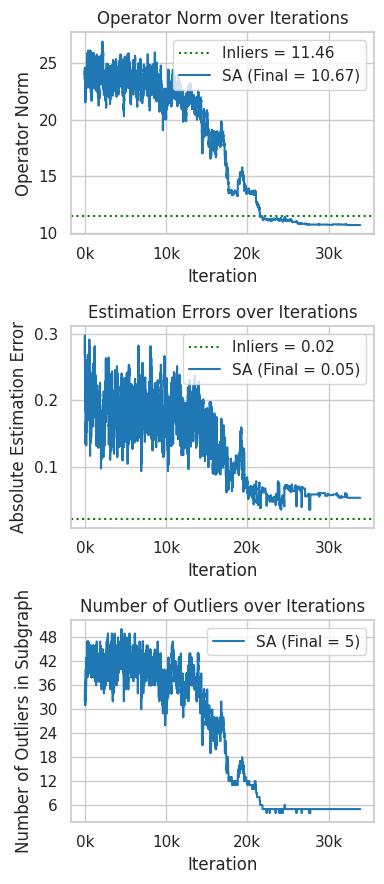

In [ ]:
# Visualize results
sa_experiment.visualize(
    costs_axis_lim = None,
    errors_axis_lim = None,
    smoothing_window = None,
    vertical = True,
    figsize = (4, 9),
    G_for_inliers_baseline=G_test,
)

In [ ]:
# You can also directly access logs / results
print("SA initial temp.:", sa_experiment.result_temperature_initialization)
print("SA initial estimation error:", sa_experiment.logs.errors[0])
print("SA final operator norm:", sa_experiment.results.cost)
print("SA final estimation error:", sa_experiment.results.estimation_error)
print("SA outlier count:", sa_experiment.results.outlier_count)
print("SA overlap:", Experiment.overlap(G_test.z[sa_experiment.results.solution],
                                        sa_experiment.results.z_hat,
                                        graph_config.K)[0])

SA initial temp.: 2.25
SA initial estimation error: (0.267, 0.162)
SA final operator norm: 10.673777300104272
SA final estimation error: (0.053, 0.032)
SA outlier count: 5
SA overlap: 1.0


In [ ]:
# To save an experiment, uncomment:
# save_name = f"ideal_SA_seed_{seed}.pkl"
# sa_experiment.save(filename=save_name)
# To load an experiment, uncomment:
load_name = "ideal_SA_seed_12345.pkl"
sa_experiment = SimulatedAnnealing.load(filename=load_name)

Experiment loaded from ideal_SA_seed_12345.pkl.


#### Filtering

In [ ]:
# Configure the filtering experiment while instantiating it
filtering_experiment = Filtering(
    perturbed_graph_generator,
    n_filtering_steps=100,
)

In [ ]:
filtering_experiment.run(G_test)

filtering:   0%|          | 0/100 [00:00<?, ?it/s]

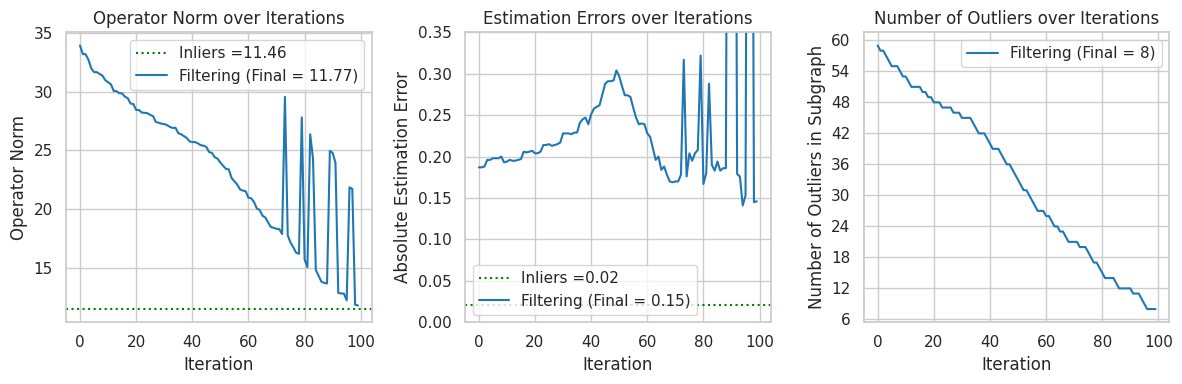

In [ ]:
filtering_experiment.visualize(
    G_for_inliers_baseline=G_test,
    errors_axis_lim=0.35,
    vertical=False,
    # figsize=(4, 9),
)

#### Pruning

In [ ]:
pruning_experiment = Pruning(
    perturbed_graph_generator,
    num_to_prune=int(perturbation_config.gamma*G_test.n)
)

In [ ]:
pruning_experiment.run(G_test)

In [ ]:
pruning_experiment.results.estimation_error

(0.353, 0.214)

In [ ]:
pruning_experiment.results.cost

22.14707232372265

In [ ]:
len(pruning_experiment.results.G.corrupt_idx)

27

### Dependence on $\gamma$

In [ ]:
# Configure simulated annealing
sa_config_error_vs_pert = SimulatedAnnealingConfig(
    subgraph_size = 160,
    n_iters_outer = 1000,
    n_iters_inner = 40,
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Configure multi-run experiment
error_vs_pert_config = ErrorVsPerturbationConfig(
    gamma_grid = np.arange(0.1, 0.4, 0.05),
    graphs_per_gamma = 10,
    runs_per_graph = 3,
    adaptive = False,
    min_n_iters_inner = None,
    max_n_iters_inner = None,
    min_n_iters_outer = None,
    max_n_iters_outer = None,
    min_cooling_rate = None,
    max_cooling_rate = None,
)

# Instantiate multi-run experiment
error_test = ErrorVsPerturbation(
    perturbed_graph_generator,
    sa_config_error_vs_pert,
    error_vs_pert_config,
)

In [ ]:
# Run it!
error_test.run()

In [ ]:
# To save
# with open(f"multirun_gamma_seed_{seed}_VERY_LONG.pkl", 'wb') as f:
#   pickle.dump(error_test, f)
# To load
# with open("multirun_gamma_seed_12345_FAST.pkl", 'rb') as f:
#   error_test = pickle.load(f)

__main__.RandomSubgraph

In [ ]:
# Decided I didn't want the random subgraph baseline
# error_test.experiment_classes.pop('RandomSubgraph')

In [ ]:
# Visualize results
error_test.visualize()

### Dependence on connectivity gap $p - q$

In [ ]:
sa_config_error_vs_gap = SimulatedAnnealingConfig(
    subgraph_size = 140,
    n_iters_outer = 1000,
    n_iters_inner = 1,
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Configure multi-run experiment
error_vs_gap_config = ErrorVsGapConfig(
    epsilons = np.arange(0.01, 0.21, 0.03),
    graphs_per_epsilon = 10,
    runs_per_graph = 3,
    adaptive = False,
    min_n_iters_inner = 1,
    max_n_iters_inner = 1,
    min_n_iters_outer = 1000,
    max_n_iters_outer = 1000,
    min_cooling_rate = 0.98,
    max_cooling_rate = 0.98,
)

# Instantiate multi-run experiment
error_vs_gap = ErrorVsGap(
    perturbed_graph_generator,
    sa_config_error_vs_gap,
    error_vs_gap_config,
)

In [ ]:
error_vs_gap.run()

In [ ]:
# To save
# with open(f"multirun_gap_seed_{seed}_VERY_LONG.pkl", 'wb') as f:
#   pickle.dump(error_vs_gap, f)
# To load
# with open("multirun_gap_seed_12345_FAST.pkl", 'rb') as f:
#   error_vs_gap = pickle.load(f)

In [ ]:
# If you want to not show some of the experiments
error_vs_gap.experiment_classes.pop('RandomSubgraph')
error_vs_gap.experiment_classes.pop('Filtering')

In [ ]:
error_vs_gap.visualize()

### Dependence on $n$

In [ ]:
sa_config_norm_vs_n = SimulatedAnnealingConfig(
    subgraph_size = 140,  # Does not matter (set inside multi-run)
    n_iters_outer = 1000,
    n_iters_inner = 1,  # Does not matter either (set inside)
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Configure multi-run experiment
norm_vs_n_config = NormVsNConfig(
    n_grid = np.arange(250, 750, 250),
    graphs_per_n = 2,
    runs_per_graph = 1,
)

# Instantiate multi-run experiment
norm_vs_n = NormVsN(
    perturbed_graph_generator,
    sa_config_norm_vs_n,
    norm_vs_n_config,
)

In [ ]:
norm_vs_n.run()

In [ ]:
# To save
# with open(f"multirun_n_seed_{seed}_TEST.pkl", 'wb') as f:
#   pickle.dump(norm_vs_n, f)
# To load
# with open("multirun_n_seed_12345_part_1.pkl", 'rb') as f:
#   norm_vs_n_1 = pickle.load(f)

In [ ]:
# Some surgery (I did the experiment in multiple parts)
with open("multirun_n_seed_12345_part_1.pkl", 'rb') as f:
  norm_vs_n_1 = pickle.load(f)
with open("multirun_n_seed_12345_part_2.pkl", 'rb') as f:
  norm_vs_n_2 = pickle.load(f)
with open("multirun_n_seed_12345_part_3.pkl", 'rb') as f:
  norm_vs_n_3 = pickle.load(f)
with open("multirun_n_seed_12345_part_4.pkl", 'rb') as f:
  norm_vs_n_4 = pickle.load(f)

norm_vs_n_1.multi_run_results['SimulatedAnnealing'].extend(norm_vs_n_2.multi_run_results['SimulatedAnnealing'])
norm_vs_n_1.multi_run_results['SimulatedAnnealing'].extend(norm_vs_n_3.multi_run_results['SimulatedAnnealing'])
norm_vs_n_1.multi_run_results['SimulatedAnnealing'].extend(norm_vs_n_4.multi_run_results['SimulatedAnnealing'])
norm_vs_n_1.multi_run_results['Inliers'].extend(norm_vs_n_2.multi_run_results['Inliers'])
norm_vs_n_1.multi_run_results['Inliers'].extend(norm_vs_n_3.multi_run_results['Inliers'])
norm_vs_n_1.multi_run_results['Inliers'].extend(norm_vs_n_4.multi_run_results['Inliers'])

norm_vs_n_1.graphs.extend(norm_vs_n_2.graphs)
norm_vs_n_1.graphs.extend(norm_vs_n_3.graphs)
norm_vs_n_1.graphs.extend(norm_vs_n_4.graphs)

norm_vs_n_1.experiments['SimulatedAnnealing'].extend(norm_vs_n_2.experiments['SimulatedAnnealing'])
norm_vs_n_1.experiments['SimulatedAnnealing'].extend(norm_vs_n_3.experiments['SimulatedAnnealing'])
norm_vs_n_1.experiments['SimulatedAnnealing'].extend(norm_vs_n_4.experiments['SimulatedAnnealing'])
norm_vs_n_1.experiments['Inliers'].extend(norm_vs_n_2.experiments['Inliers'])
norm_vs_n_1.experiments['Inliers'].extend(norm_vs_n_3.experiments['Inliers'])
norm_vs_n_1.experiments['Inliers'].extend(norm_vs_n_4.experiments['Inliers'])

norm_vs_n_1.norm_vs_n_config.n_grid = np.arange(100, 550, 50)

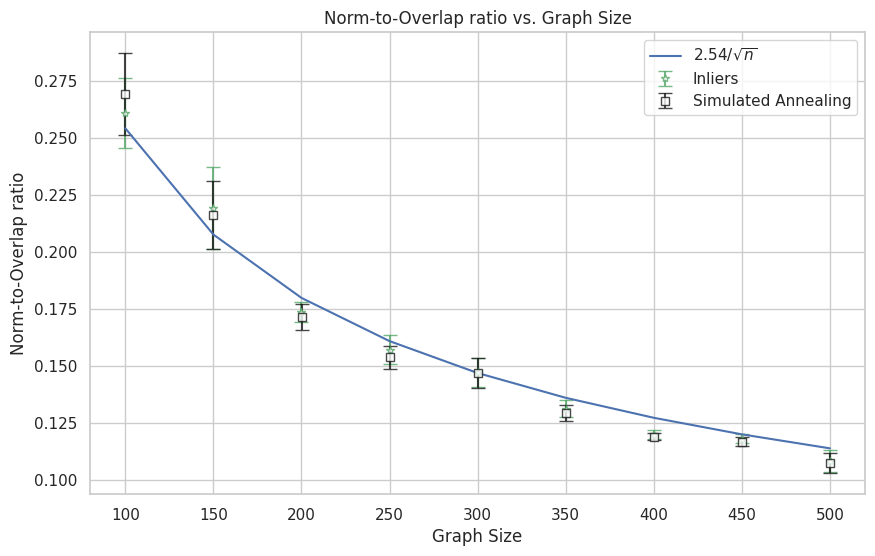

In [ ]:
norm_vs_n_1.visualize()

### Application to Real Graphs

#### Political Blogs

##### Load Data

In [ ]:
K = 2
gamma = 0.2

G_polblogs = Graph.load_from_edge_csv(filepath="polblogs_edges.csv", K=K)
G_polblogs, _ = G_polblogs.remove_small_components()
pos_polblogs = G_polblogs.pos()

In [ ]:
seed_polblogs=12345

# Configure graph generator
graph_polblogs_config = GraphGeneratorConfig(
    n = G_polblogs.n,
    K = K,
    p = 0.0,
    q = 0.0,
)

# Configure perturbation
perturbation_polblogs_config = PerturbedGraphGeneratorConfig(
    gamma = gamma,
    frac_max_var = 0.95,
)

# Instantiate generator
perturbed_graph_generator_polblogs = PerturbedGraphGenerator(
    seed = seed_polblogs,
    config = graph_polblogs_config,
    perturbation_config = perturbation_polblogs_config,
)

##### Simulated Annealing

In [ ]:
sa_polblogs_config = SimulatedAnnealingConfig(
    subgraph_size = int((1 - gamma)*G_polblogs.n),
    n_iters_outer = 1000,
    n_iters_inner = 10,
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Instantiate it
sa_polblogs_experiment = SimulatedAnnealing(
    perturbed_graph_generator_polblogs,
    sa_polblogs_config
)

In [ ]:
sa_polblogs_experiment.run(G_polblogs)

SA:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# To save
# save_name = f"sa_polblogs_seed_{seed_polblogs}_gamma_02.pkl"
# sa_polblogs_experiment.save(save_name)

# To load
sa_polblogs_experiment = SimulatedAnnealing.load("sa_polblogs_seed_12345_gamma_02.pkl")

Experiment loaded from sa_polblogs_seed_12345_gamma_02.pkl.


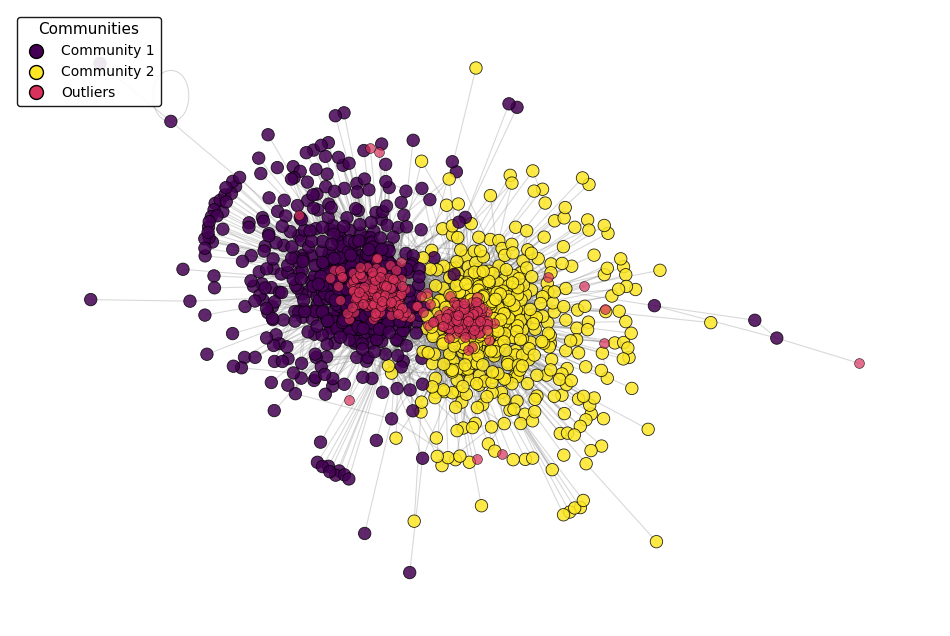

In [ ]:
sa_polblogs_experiment.visualize_graph_with_outliers(G_polblogs,
                                                     pos=pos_polblogs)

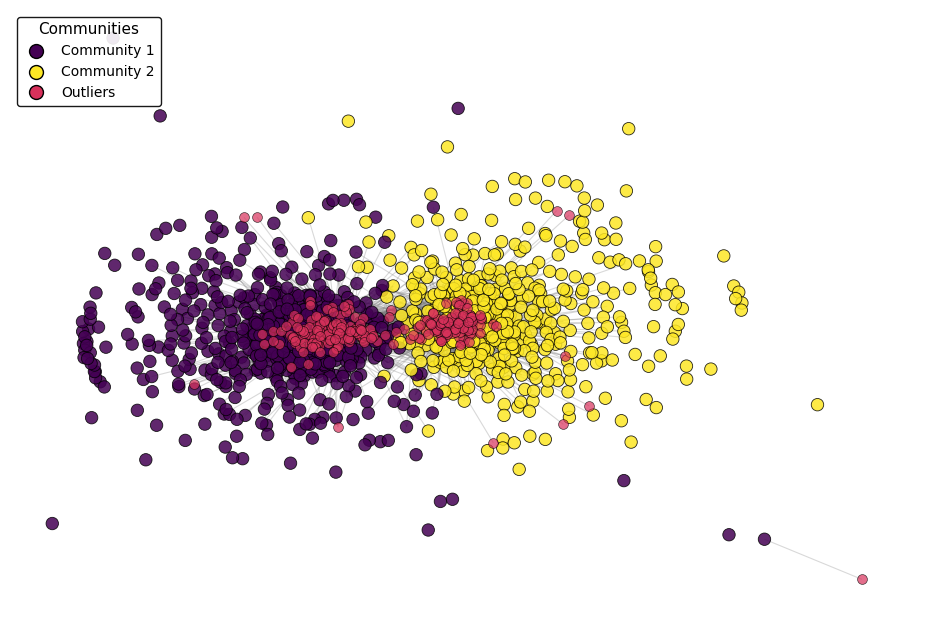

In [ ]:
sa_polblogs_experiment.visualize_graph_only_outlier_edges(G_polblogs,
                                                          pos=pos_polblogs)

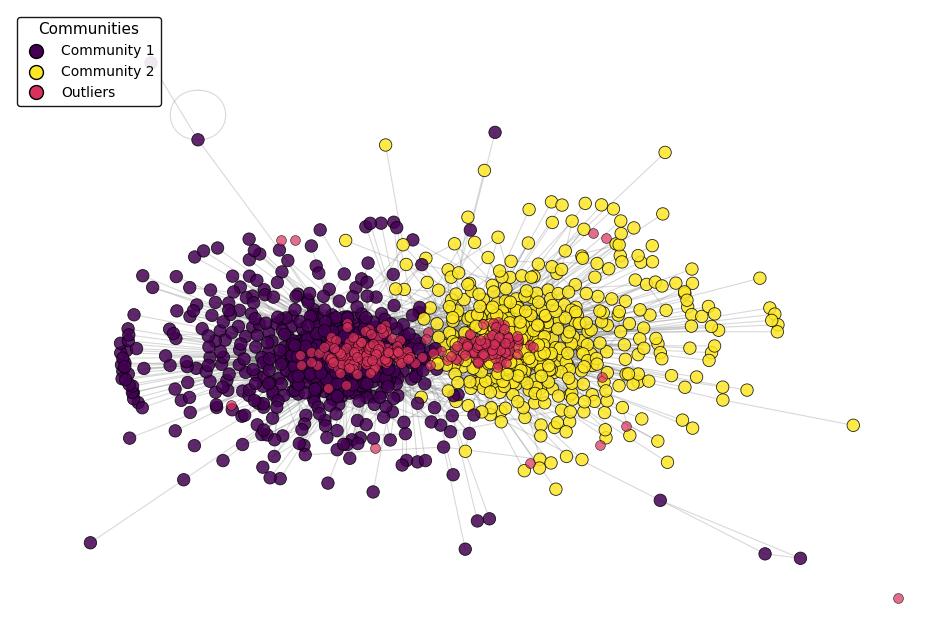

In [ ]:
sa_polblogs_experiment.visualize_graph_only_inlier_edges(G_polblogs,
                                                         pos=pos_polblogs)

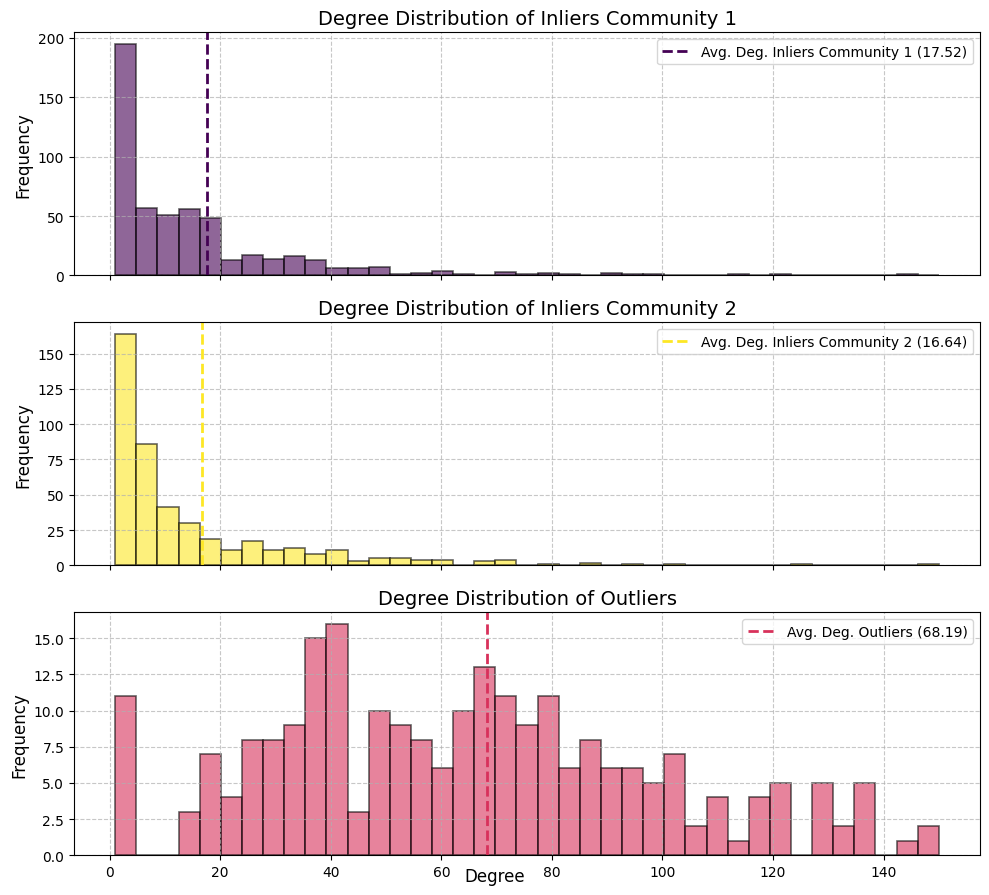

In [ ]:
sa_polblogs_experiment.visualize_histogram(G_polblogs)

In [ ]:
sa_polblogs_experiment.results.Gamma_hat

array([[0.017, 0.001],
       [0.001, 0.017]])

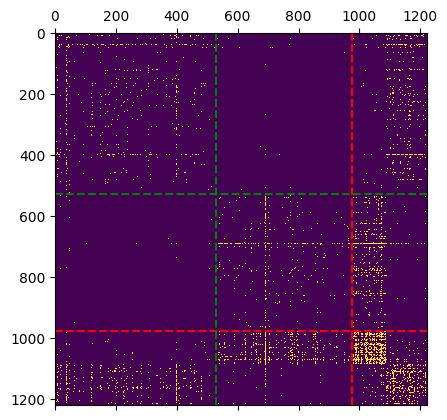

In [ ]:
# @title
# ADJACENCY MATRIX PLOT --> MOVE TO METHOD IN CLASS
solution = sa_polblogs_experiment.results.solution
z_hat = sa_polblogs_experiment.results.z_hat

ordered_solution = solution[np.argsort(z_hat)]
nodes_outside_solution = np.setdiff1d(np.arange(G_polblogs.n), solution)
new_order = np.concatenate((ordered_solution, nodes_outside_solution))
G_ordered = G_polblogs.subgraph(new_order)

n_inside = len(solution)
n_outside = len(nodes_outside_solution)
boundary_communities = np.where(np.diff(np.sort(z_hat)))[0] + 1

plt.matshow(G_ordered.A)
plt.axvline(x=n_inside - 0.5, color='red', linestyle='--')
plt.axhline(y=n_inside - 0.5, color='red', linestyle='--')
for xc in boundary_communities:
    plt.axvline(x=xc - 0.5, color='green', linestyle='--')
    plt.axhline(y=xc - 0.5, color='green', linestyle='--')

##### Spectral Clustering

In [ ]:
sc_polblogs = Baseline(perturbed_graph_generator_polblogs)

In [ ]:
sc_polblogs.run(G_polblogs)

<ipython-input-12-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


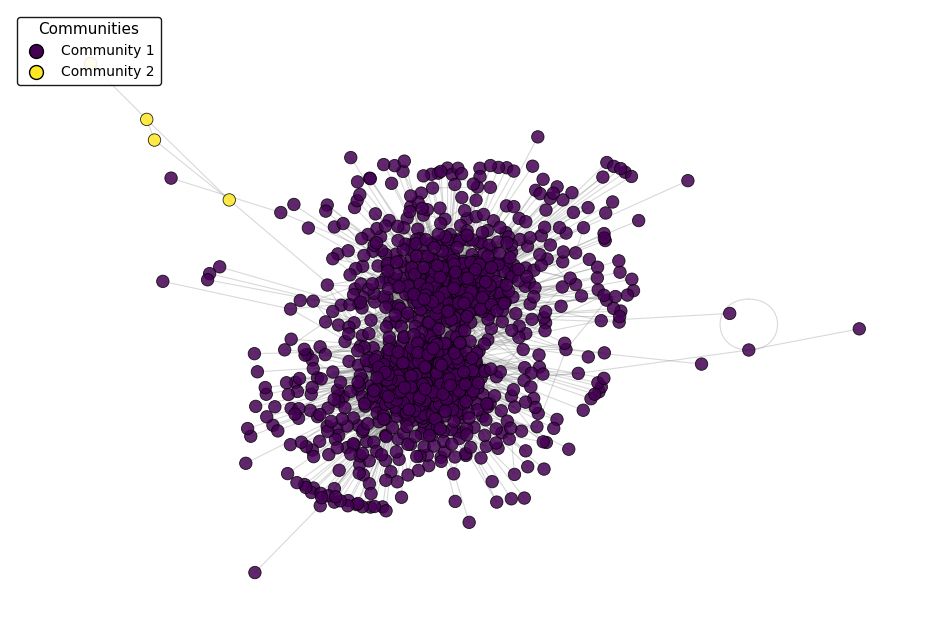

In [ ]:
sc_polblogs.visualize(pos=pos_polblogs)

In [ ]:
sc_polblogs.results.Gamma_hat

array([[2.253e-02, 2.053e-04],
       [2.053e-04, 5.000e-01]])

##### Pruning

In [ ]:
pruning_polblogs = Pruning(
    perturbed_graph_generator_polblogs,
    num_to_prune=int(gamma*G_polblogs.n)
)

In [ ]:
pruning_polblogs.run(G_polblogs)

<ipython-input-58-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)
<ipython-input-58-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


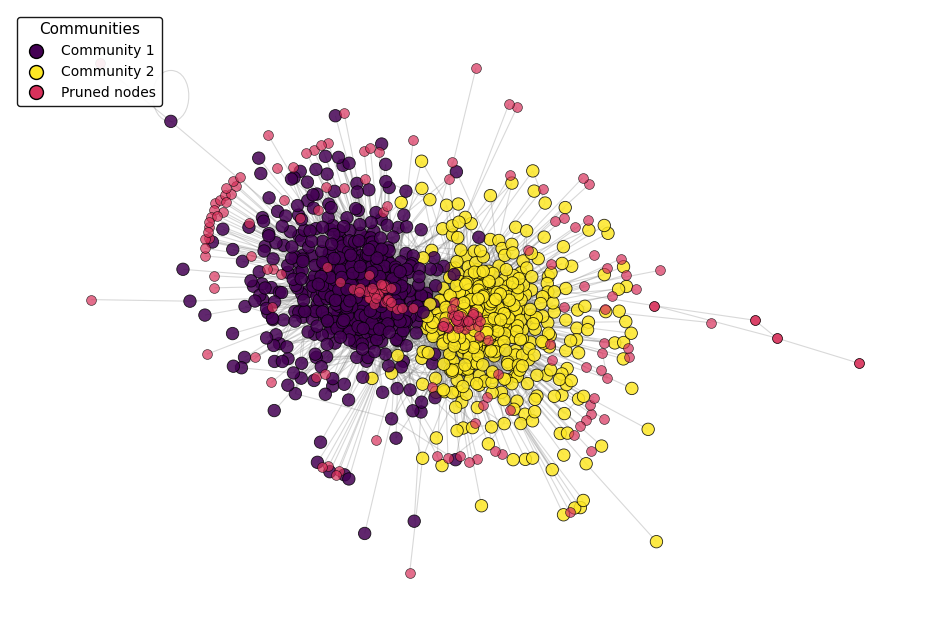

In [ ]:
pruning_polblogs.visualize(G_polblogs, pos=pos_polblogs)

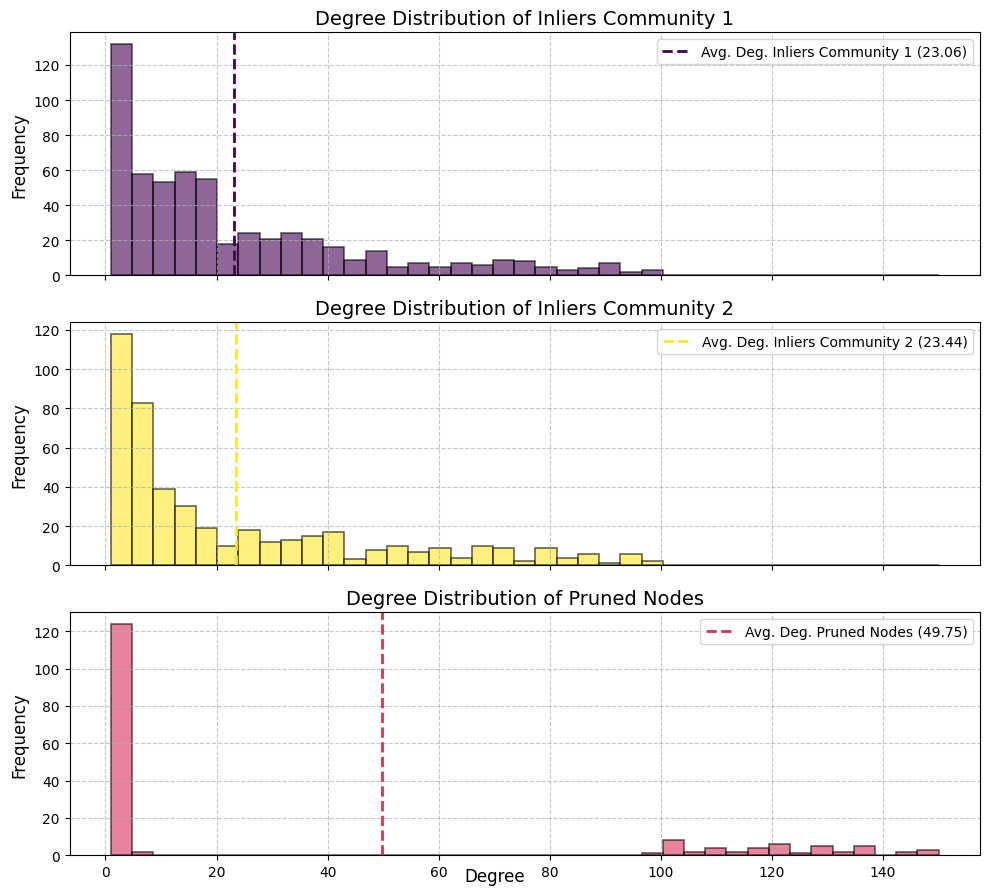

In [ ]:
pruning_polblogs.visualize_histogram(G_polblogs,
                                     include_pruned=True)

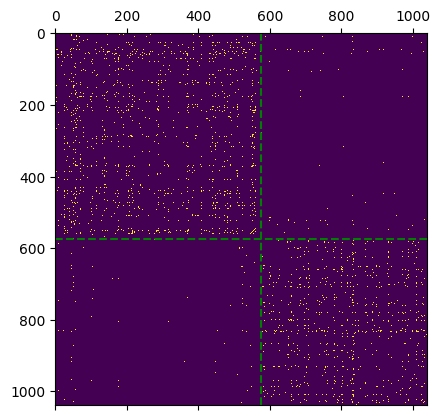

In [ ]:
z_hat_pruning = pruning_polblogs.results.z_hat
pruning_solution = np.arange(pruning_polblogs.results.G.n)

pruning_ordered_solution = pruning_solution[np.argsort(z_hat_pruning)]
G_ordered_pruning = pruning_polblogs.results.G.subgraph(pruning_ordered_solution)

boundary_communities_pruning = np.where(np.diff(np.sort(z_hat_pruning)))[0] + 1

plt.matshow(G_ordered_pruning.A)
for xc in boundary_communities_pruning:
    plt.axvline(x=xc - 0.5, color='green', linestyle='--')
    plt.axhline(y=xc - 0.5, color='green', linestyle='--')

In [ ]:
pruning_polblogs.results.Gamma_hat

array([[0.027, 0.002],
       [0.002, 0.032]])

##### DC-SBM

We use `graph-tool` to fit a DC-SBM.

In [ ]:
!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

--2024-09-26 13:07:19--  https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_jammy.deb
Resolving downloads.skewed.de (downloads.skewed.de)... 49.12.93.194
Connecting to downloads.skewed.de (downloads.skewed.de)|49.12.93.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23192 (23K) [application/x-debian-package]
Saving to: ‘skewed-keyring_1.0_all_jammy.deb’

skewed-keyring_1.0_ 100%[===================>]  22.65K  --.-KB/s    in 0.1s    

2024-09-26 13:07:20 (205 KB/s) - ‘skewed-keyring_1.0_all_jammy.deb’ saved [23192/23192]

Selecting previously unselected package skewed-keyring.
(Reading database ... 123605 files and directories currently installed.)
Preparing to unpack skewed-keyring_1.0_all_jammy.deb ...
Unpacking skewed-keyring (1.0) ...
Setting up skewed-keyring (1.0) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRe

In [ ]:
import graph_tool.all as gt
from scipy.sparse import lil_matrix

In [ ]:
# Transform polblogs into graph-tool's Graph class
polblogs_graph_tool = gt.Graph(
    lil_matrix(G_polblogs.A),
    directed=False
)

In [ ]:
# Fit DC-SBM by minimizing description length
state = gt.minimize_blockmodel_dl(
    polblogs_graph_tool,
    state_args=dict(deg_corr=True, B=2)
)

In [ ]:
state.get_bg()

<Graph object, undirected, with 1222 vertices and 180 edges, 1 internal edge property, at 0x7866b54ee500>

In [ ]:
state.draw(output="polblogs_graphtool.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7866b54eeb90, at 0x7866b68ad270>

#### Spanish High-School

##### Load Data

In [ ]:
K = 4
gamma = 0.15

G_hs = PerturbedGraph.load_from_edge_csv(filepath="spanish_hs_edges.csv", K=K)
G_hs, _ = G_hs.remove_small_components()
pos_hs = G_hs.pos()

In [ ]:
seed_hs = 12345

# Configure graph generator
graph_hs_config = GraphGeneratorConfig(
    n = G_hs.n,
    K = K,
    p = 0.0,
    q = 0.0,
)

# Configure perturbation
perturbation_hs_config = PerturbedGraphGeneratorConfig(
    gamma = gamma,
    frac_max_var = 0.95,
)

# Instantiate generator
perturbed_graph_generator_hs = PerturbedGraphGenerator(
    seed = seed_hs,
    config = graph_hs_config,
    perturbation_config = perturbation_hs_config,
)

##### Simulated Annealing

In [ ]:
sa_hs_config = SimulatedAnnealingConfig(
    subgraph_size = int((1 - gamma)*G_hs.n),
    n_iters_outer = 1000,
    n_iters_inner = 80,
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Instantiate it
sa_hs_experiment = SimulatedAnnealing(
    perturbed_graph_generator_hs,
    sa_hs_config
)

In [ ]:
sa_hs_experiment.run(G_hs)

SA:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# To save
# save_name = f"sa_hs_seed_{seed_hs}_gamma_15_80_inner.pkl"
# sa_hs_experiment.save(save_name)

# To load
sa_hs_experiment = SimulatedAnnealing.load("sa_hs_seed_12345_gamma_15_80_inner.pkl")

Experiment loaded from sa_hs_seed_12345_gamma_15_80_inner.pkl.


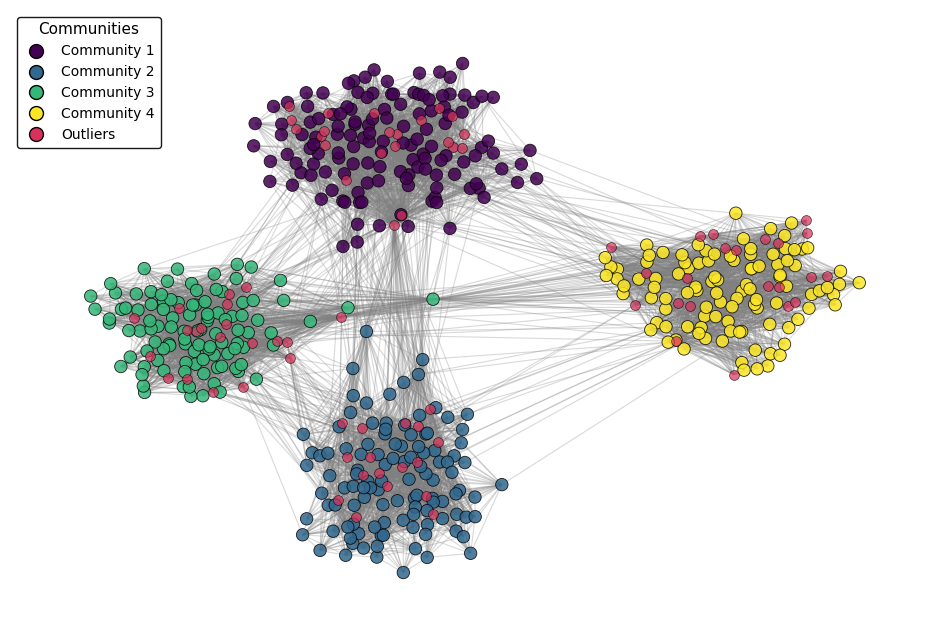

In [ ]:
sa_hs_experiment.visualize_graph_with_outliers(G_hs, pos=pos_hs)

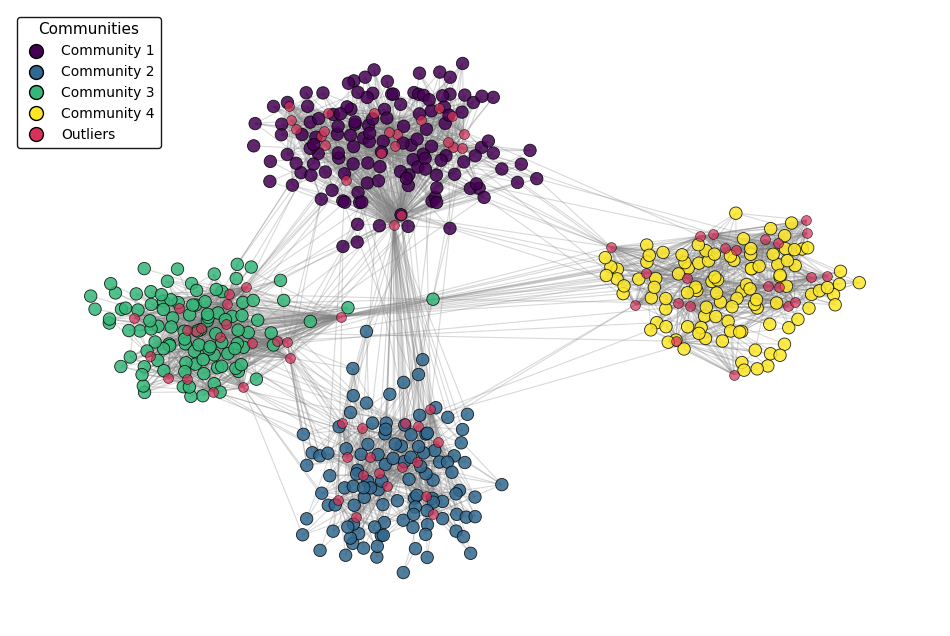

In [ ]:
sa_hs_experiment.visualize_graph_only_outlier_edges(G_hs, pos=pos_hs)

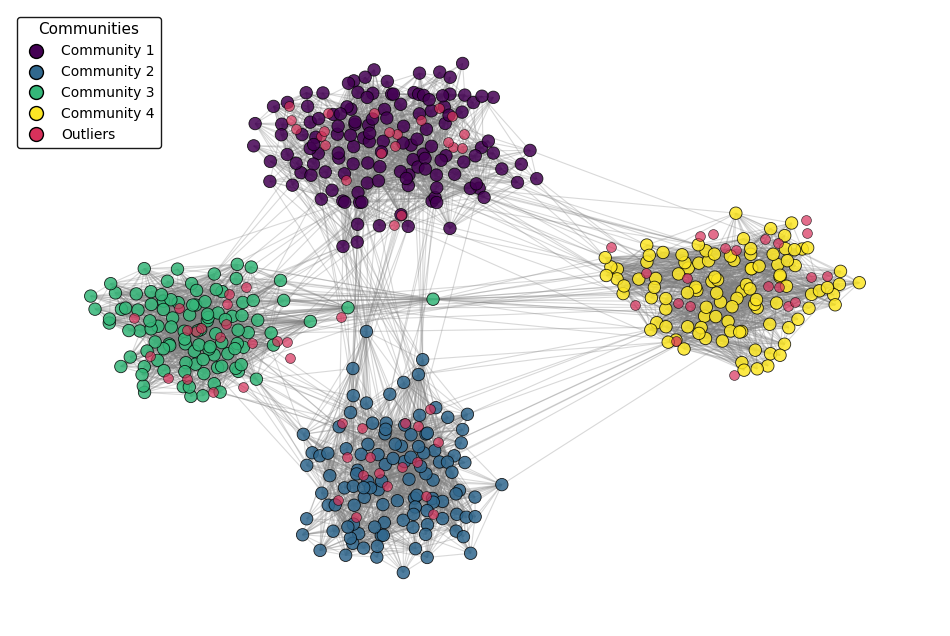

In [ ]:
sa_hs_experiment.visualize_graph_only_inlier_edges(G_hs, pos=pos_hs)

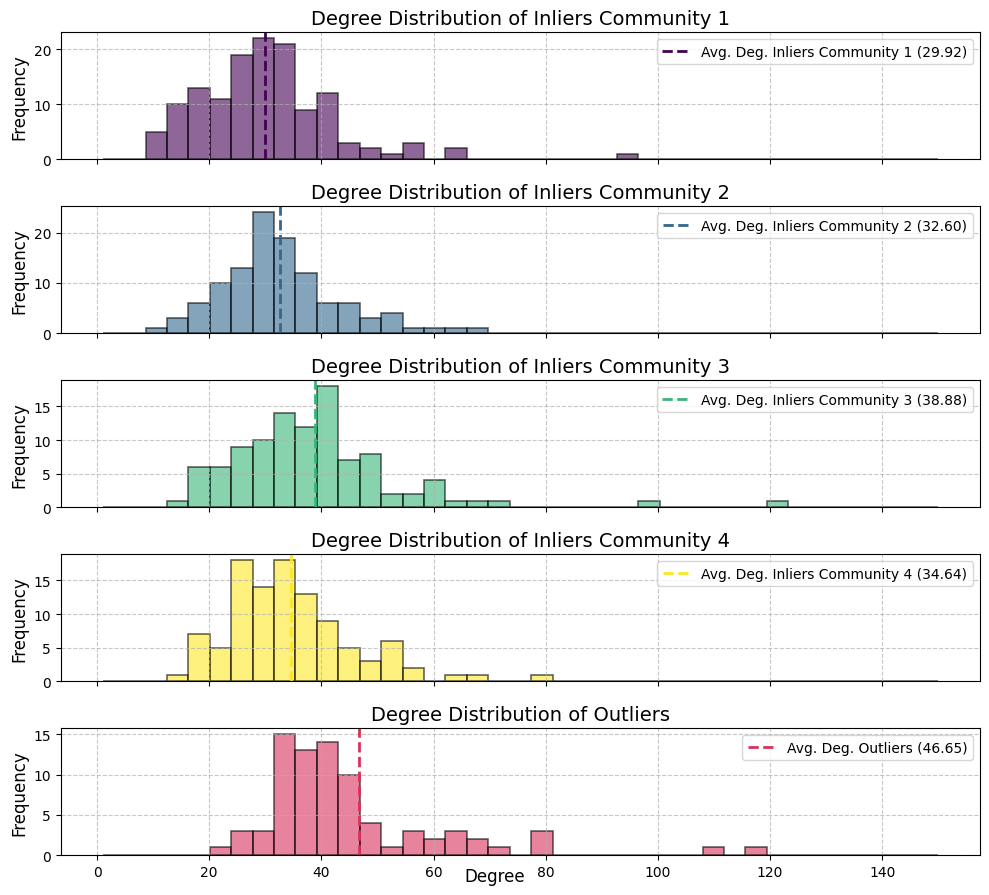

In [ ]:
sa_hs_experiment.visualize_histogram(G_hs, include_outliers=True)

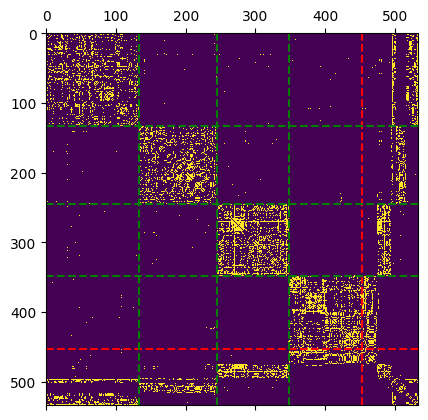

In [ ]:
# ADJACENCY MATRIX PLOT --> MOVE TO METHOD IN CLASS
solution = sa_hs_experiment.results.solution
z_hat = sa_hs_experiment.results.z_hat

ordered_solution = solution[np.argsort(z_hat)]
nodes_outside_solution = np.setdiff1d(np.arange(G_hs.n), solution)
new_order = np.concatenate((ordered_solution, nodes_outside_solution))
G_ordered = G_hs.subgraph(new_order)

n_inside = len(solution)
n_outside = len(nodes_outside_solution)
boundary_communities = np.where(np.diff(np.sort(z_hat)))[0] + 1

plt.matshow(G_ordered.A)
plt.axvline(x=n_inside - 0.5, color='red', linestyle='--')
plt.axhline(y=n_inside - 0.5, color='red', linestyle='--')
for xc in boundary_communities:
    plt.axvline(x=xc - 0.5, color='green', linestyle='--')
    plt.axhline(y=xc - 0.5, color='green', linestyle='--')

In [ ]:
sa_hs_experiment.results.Gamma_hat

array([[0.165, 0.003, 0.002, 0.002],
       [0.003, 0.235, 0.002, 0.001],
       [0.002, 0.002, 0.29 , 0.002],
       [0.002, 0.001, 0.002, 0.261]])

In [ ]:
print(f"{sa_hs_experiment.results.cost:.2f}")

15.33


##### Spectral Clustering

In [ ]:
sc_hs = Baseline(perturbed_graph_generator_hs)

In [ ]:
sc_hs.run(G_hs)

<ipython-input-12-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


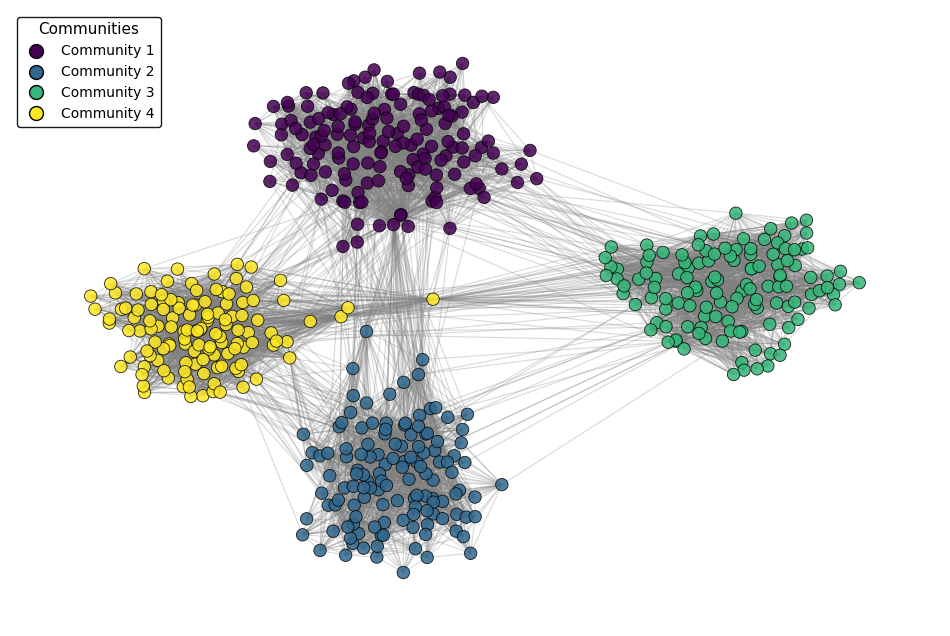

In [ ]:
sc_hs.visualize(pos=pos_hs)

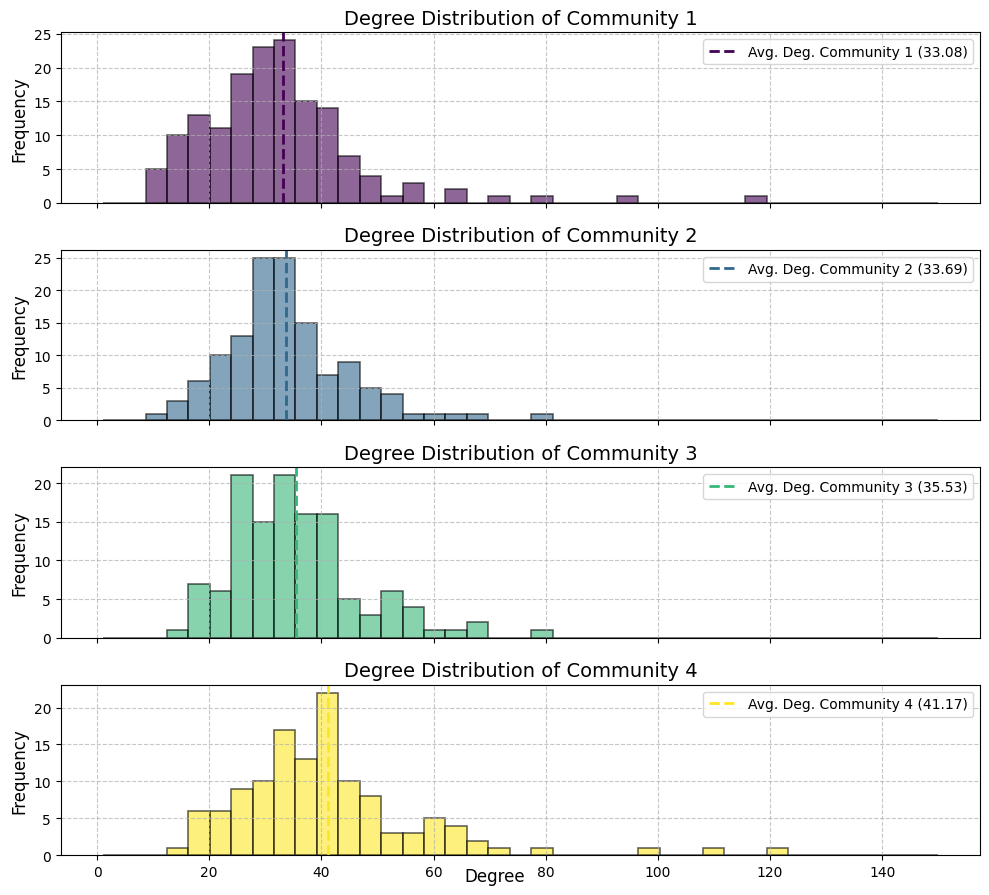

In [ ]:
sc_hs.visualize_histogram(G_hs)

In [ ]:
sc_hs.results.Gamma_hat

array([[0.204, 0.005, 0.002, 0.003],
       [0.005, 0.252, 0.001, 0.004],
       [0.002, 0.001, 0.275, 0.003],
       [0.003, 0.004, 0.003, 0.321]])

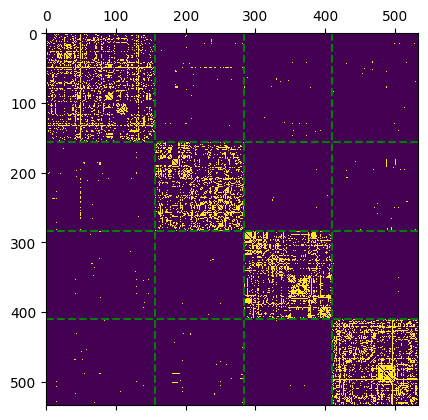

In [ ]:
z_hat_sc = sc_hs.results.z_hat
sc_solution = np.arange(G_hs.n)

sc_ordered_solution = sc_solution[np.argsort(z_hat_sc)]
G_ordered_sc = G_hs.subgraph(sc_ordered_solution)

boundary_communities_sc = np.where(np.diff(np.sort(z_hat_sc)))[0] + 1

plt.matshow(G_ordered_sc.A)
for xc in boundary_communities_sc:
    plt.axvline(x=xc - 0.5, color='green', linestyle='--')
    plt.axhline(y=xc - 0.5, color='green', linestyle='--')

##### Pruning

In [ ]:
pruning_hs = Pruning(
    perturbed_graph_generator_hs,
    num_to_prune=int(gamma*G_hs.n)
)

In [ ]:
pruning_hs.run(G_hs)

<ipython-input-59-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)
<ipython-input-59-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


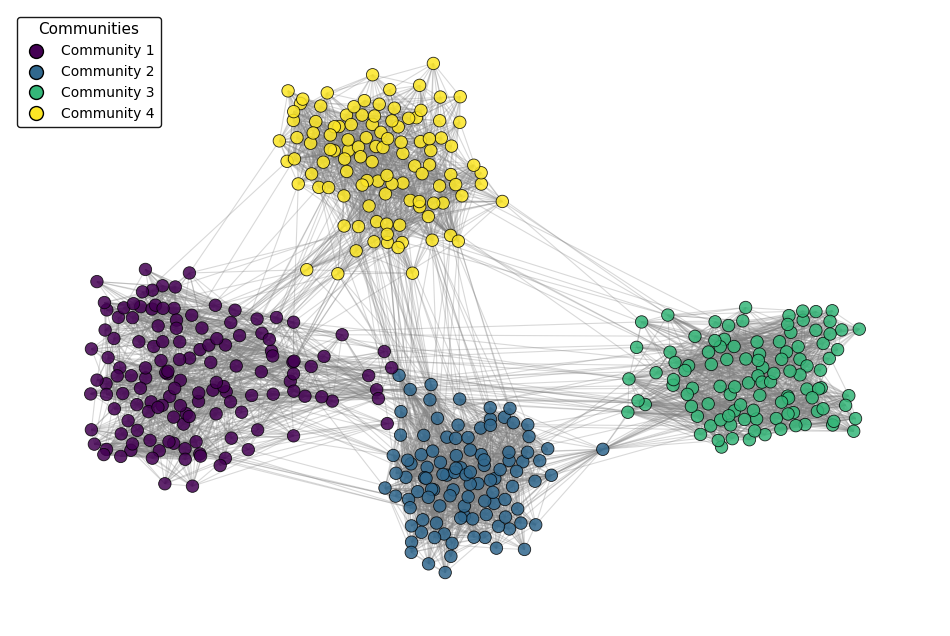

In [ ]:
pruning_hs.visualize()

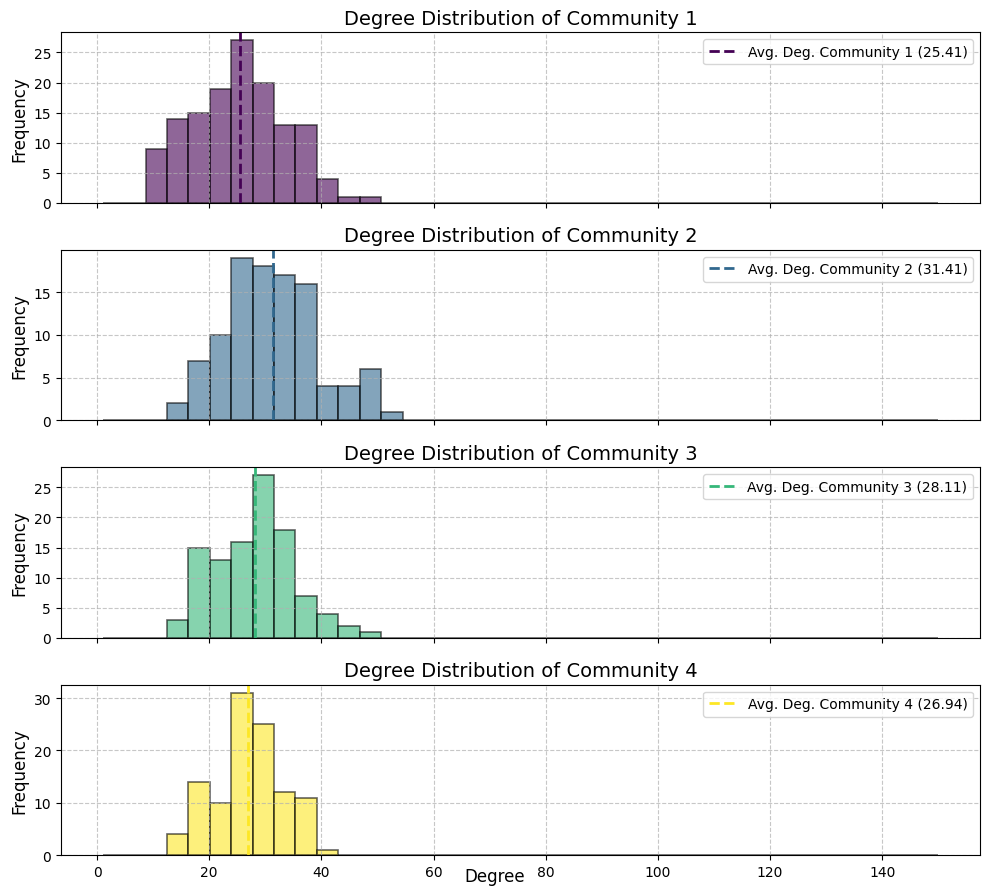

In [ ]:
pruning_hs.visualize_histogram(pruning_hs.results.G)

In [ ]:
pruning_hs.results.Gamma_hat

array([[0.18 , 0.003, 0.002, 0.003],
       [0.003, 0.29 , 0.002, 0.005],
       [0.002, 0.002, 0.259, 0.001],
       [0.003, 0.005, 0.001, 0.239]])

In [ ]:
print(f"{pruning_hs.results.cost:.2f}")

20.76


#### Political Books

##### Load Data

In [ ]:
K = 2
gamma = 0.2

G_polbooks = Graph.load_from_edge_csv(filepath="polbooks_edges.csv", K=K)
G_polbooks, _ = G_polbooks.remove_small_components()

In [ ]:
seed_polbooks=12345

# Configure graph generator
graph_polbooks_config = GraphGeneratorConfig(
    n = G_polbooks.n,
    K = K,
    p = 0.0,
    q = 0.0,
)

# Configure perturbation
perturbation_polbooks_config = PerturbedGraphGeneratorConfig(
    gamma = gamma,
    frac_max_var = 0.95,
)

# Instantiate generator
perturbed_graph_generator_polbooks = PerturbedGraphGenerator(
    seed = seed_polbooks,
    config = graph_polbooks_config,
    perturbation_config = perturbation_polbooks_config,
)

##### Simulated Annealing

In [ ]:
sa_polbooks_config = SimulatedAnnealingConfig(
    subgraph_size = int((1 - gamma)*G_polbooks.n),
    n_iters_outer = 1000,
    n_iters_inner = 20,
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Instantiate it
sa_polbooks_experiment = SimulatedAnnealing(
    perturbed_graph_generator_polbooks,
    sa_polbooks_config
)

In [ ]:
sa_polbooks_experiment.run(G_polbooks)

SA:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# To save
# save_name = f"sa_polbooks_seed_{seed_polbooks}_gamma_20.pkl"
# sa_polbooks_experiment.save(save_name)

# To load
sa_polbooks_experiment = SimulatedAnnealing.load("sa_polbooks_seed_12345_gamma_20.pkl")

Experiment saved to sa_polbooks_seed_12345_gamma_20.pkl.


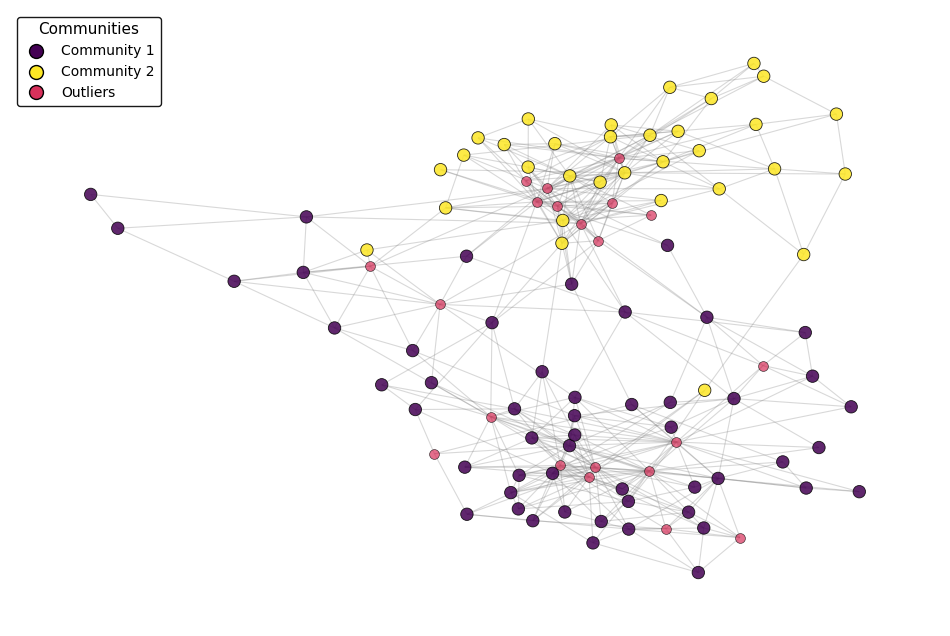

In [ ]:
sa_polbooks_experiment.visualize_graph_with_outliers(G_polbooks)

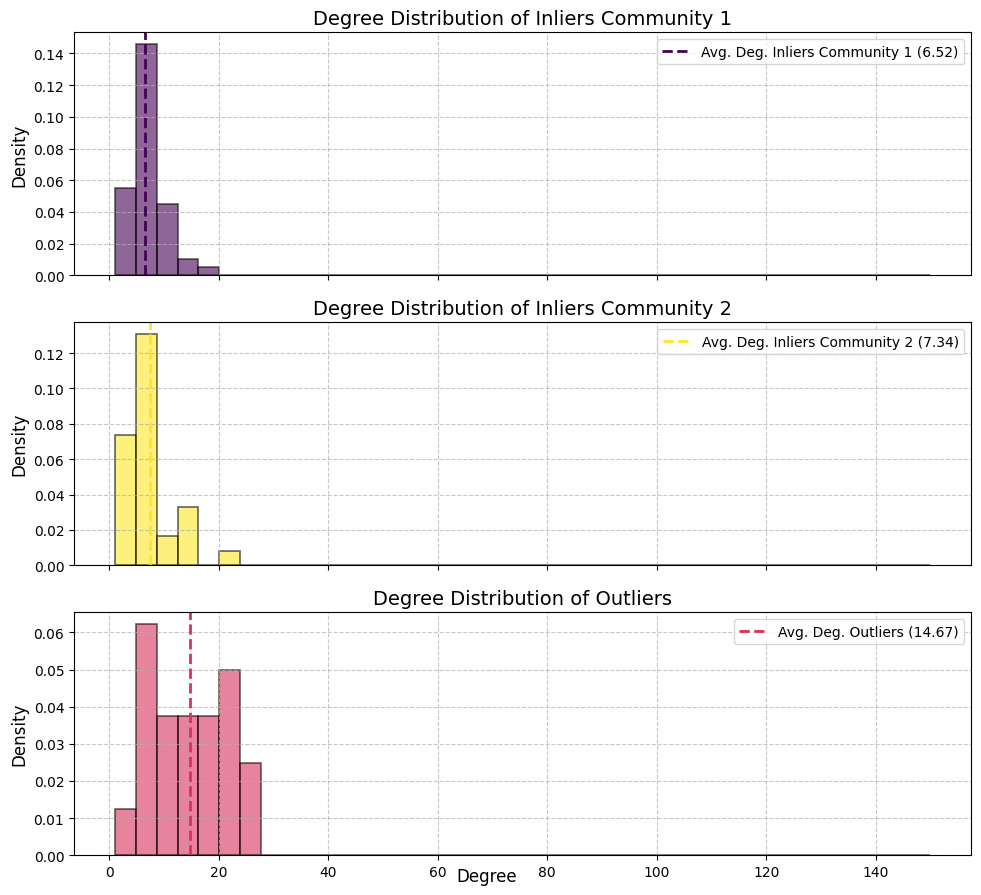

In [ ]:
sa_polbooks_experiment.visualize_histogram(G_polbooks)

##### Spectral Clustering

In [ ]:
sc_polbooks = Baseline(perturbed_graph_generator_polbooks)

In [ ]:
sc_polbooks.run(G_polbooks)

<ipython-input-13-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


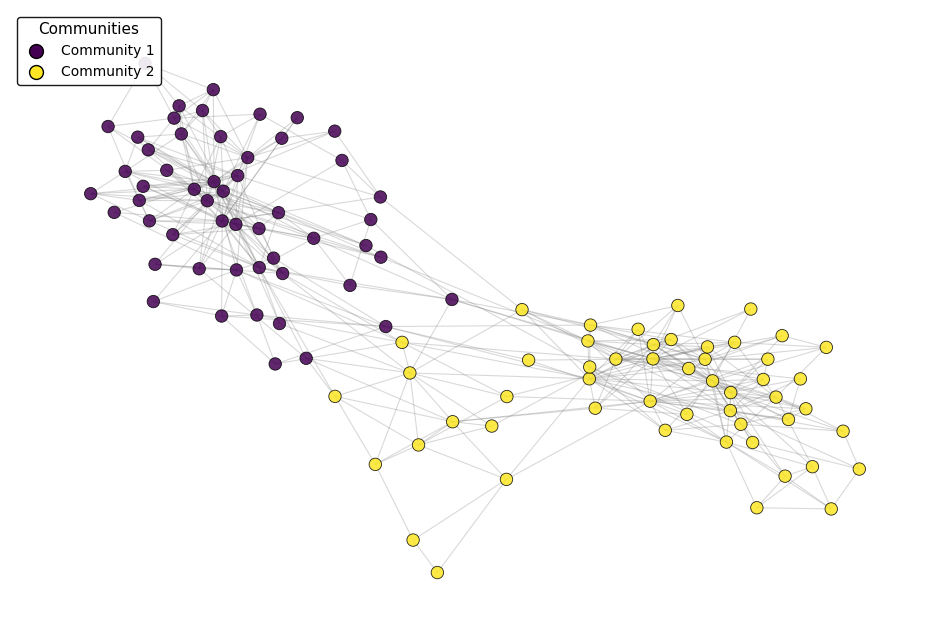

In [ ]:
sc_polbooks.visualize()

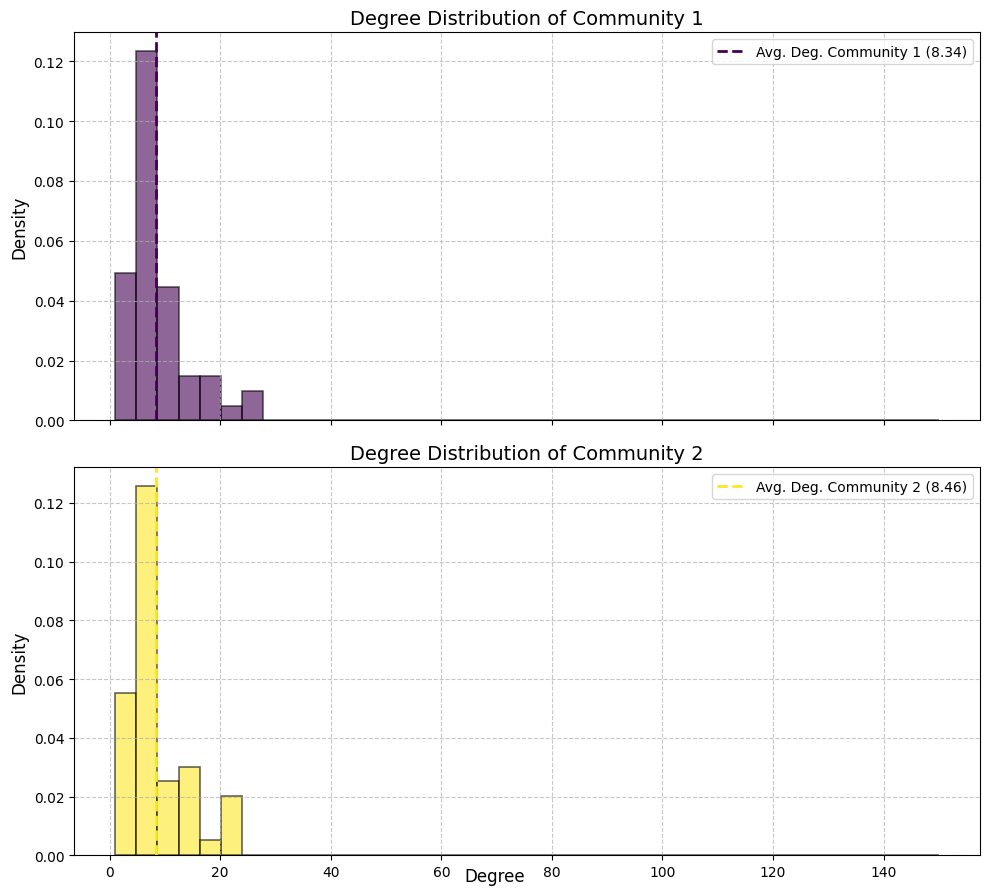

In [ ]:
sc_polbooks.visualize_histogram(G_polbooks)

In [ ]:
sc_polbooks.results.Gamma_hat

array([[0.15 , 0.007],
       [0.007, 0.155]])

##### Pruning

In [ ]:
pruning_polbooks = Pruning(
    perturbed_graph_generator_polbooks,
    num_to_prune=int(gamma*G_polbooks.n)
)

In [ ]:
pruning_polbooks.run(G_polbooks)

<ipython-input-13-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)
<ipython-input-13-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


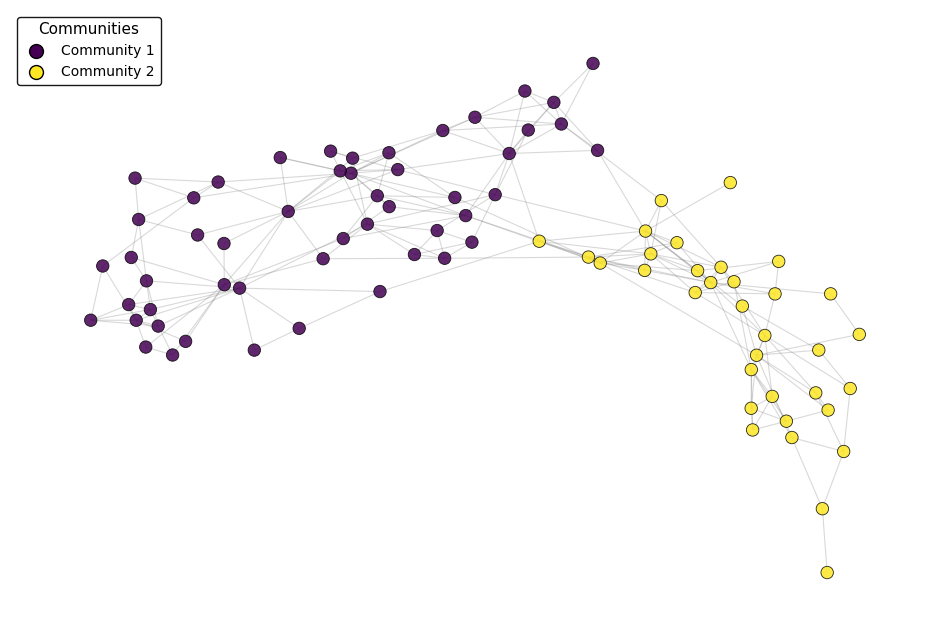

In [ ]:
pruning_polbooks.visualize()

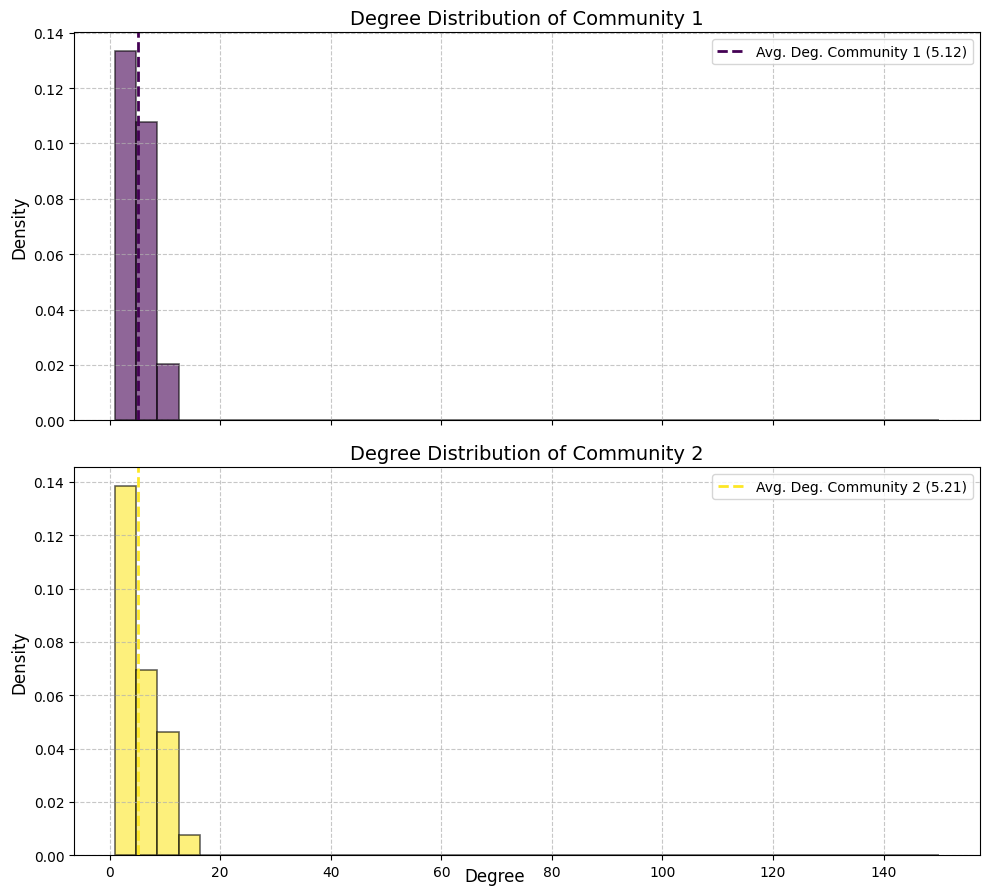

In [ ]:
pruning_polbooks.visualize_histogram(pruning_polbooks.results.G)

In [ ]:
pruning_polbooks.results.Gamma_hat

array([[0.097, 0.005],
       [0.005, 0.145]])

#### Jazz Collaboration

##### Load Data

In [ ]:
K = 3
gamma = 0.1

G_jazz = Graph.load_from_edge_csv(filepath="jazz_edges.csv", K=K)
G_jazz, _ = G_jazz.remove_small_components()
pos_jazz = G_jazz.pos()

In [ ]:
seed_jazz=12345

# Configure graph generator
graph_jazz_config = GraphGeneratorConfig(
    n = G_jazz.n,
    K = K,
    p = 0.0,
    q = 0.0,
)

# Configure perturbation
perturbation_jazz_config = PerturbedGraphGeneratorConfig(
    gamma = gamma,
    frac_max_var = 0.95,
)

# Instantiate generator
perturbed_graph_generator_jazz = PerturbedGraphGenerator(
    seed = seed_jazz,
    config = graph_jazz_config,
    perturbation_config = perturbation_jazz_config,
)

##### Simulated Annealing

In [ ]:
sa_jazz_config = SimulatedAnnealingConfig(
    subgraph_size = int((1 - gamma)*G_jazz.n),
    n_iters_outer = 1000,
    n_iters_inner = int(gamma*G_jazz.n),
    tolerance = 1e-4,
    n_iters_tolerance = 25,
    initial_temperature = None,
    cooling_rate = 0.99,
)

# Instantiate it
sa_jazz_experiment = SimulatedAnnealing(
    perturbed_graph_generator_jazz,
    sa_jazz_config
)

In [ ]:
sa_jazz_experiment.run(G_jazz)

SA:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# To save
save_name = f"sa_jazz_seed_{seed_jazz}_gamma_01.pkl"
sa_jazz_experiment.save(save_name)

# To load
# sa_jazz_experiment = SimulatedAnnealing.load("sa_jazz_seed_12345_gamma_15.pkl")

Experiment saved to sa_jazz_seed_12345_gamma_01.pkl.


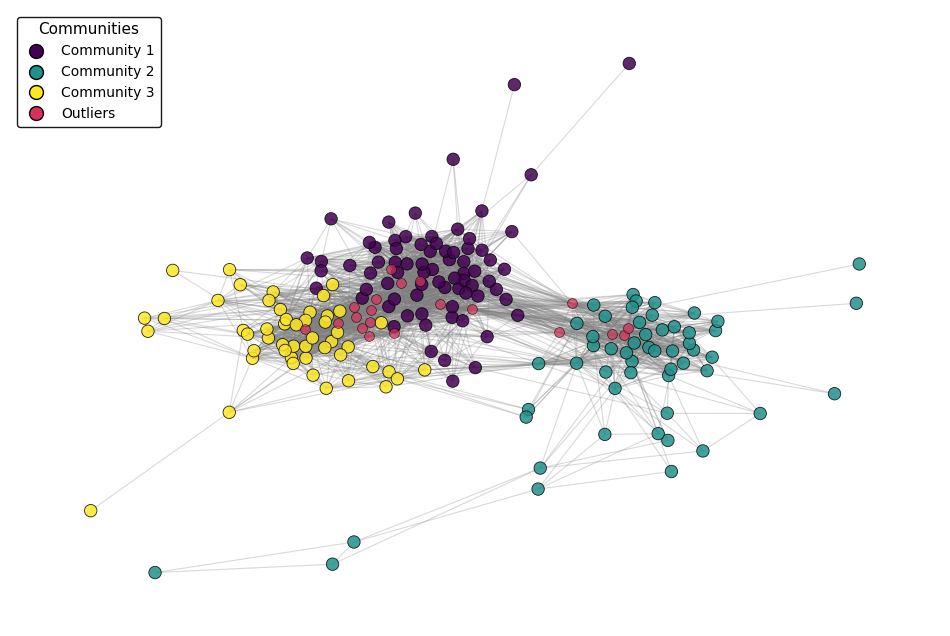

In [ ]:
sa_jazz_experiment.visualize_graph_with_outliers(G_jazz, pos=pos_jazz)

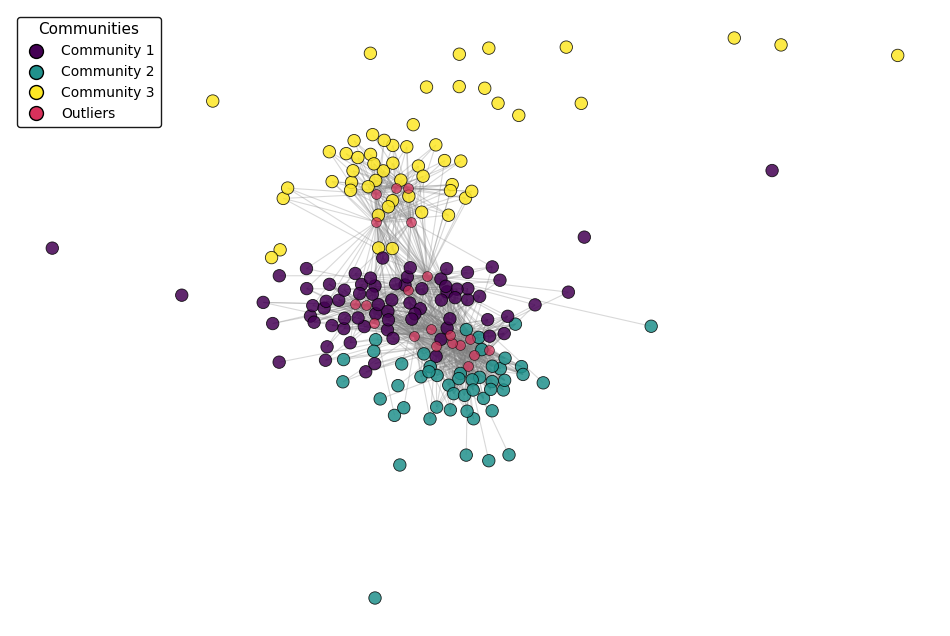

In [ ]:
sa_jazz_experiment.visualize_graph_only_outlier_edges(G_jazz, pos=pos_jazz)

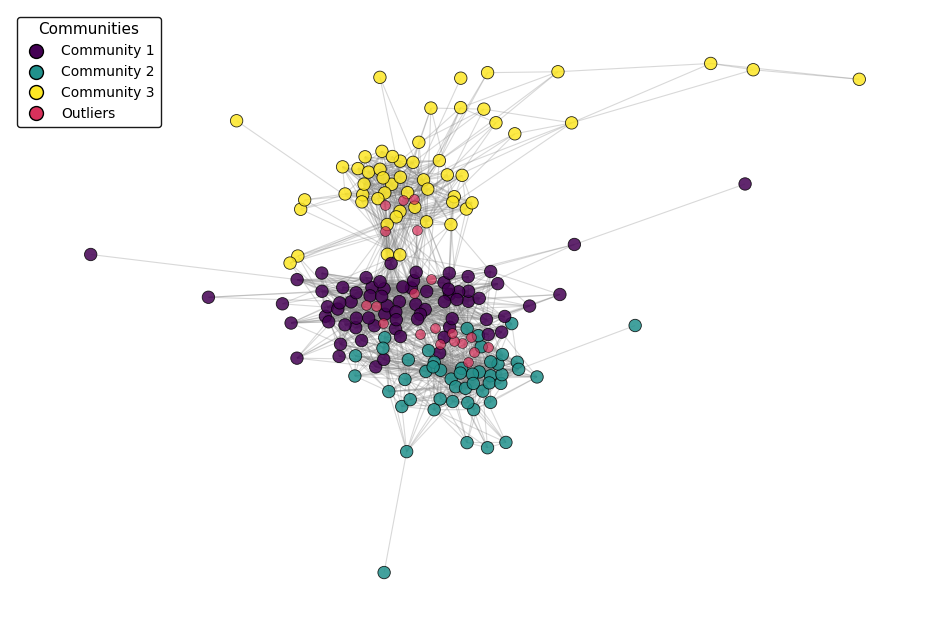

In [ ]:
sa_jazz_experiment.visualize_graph_only_inlier_edges(G_jazz, pos=pos_jazz)

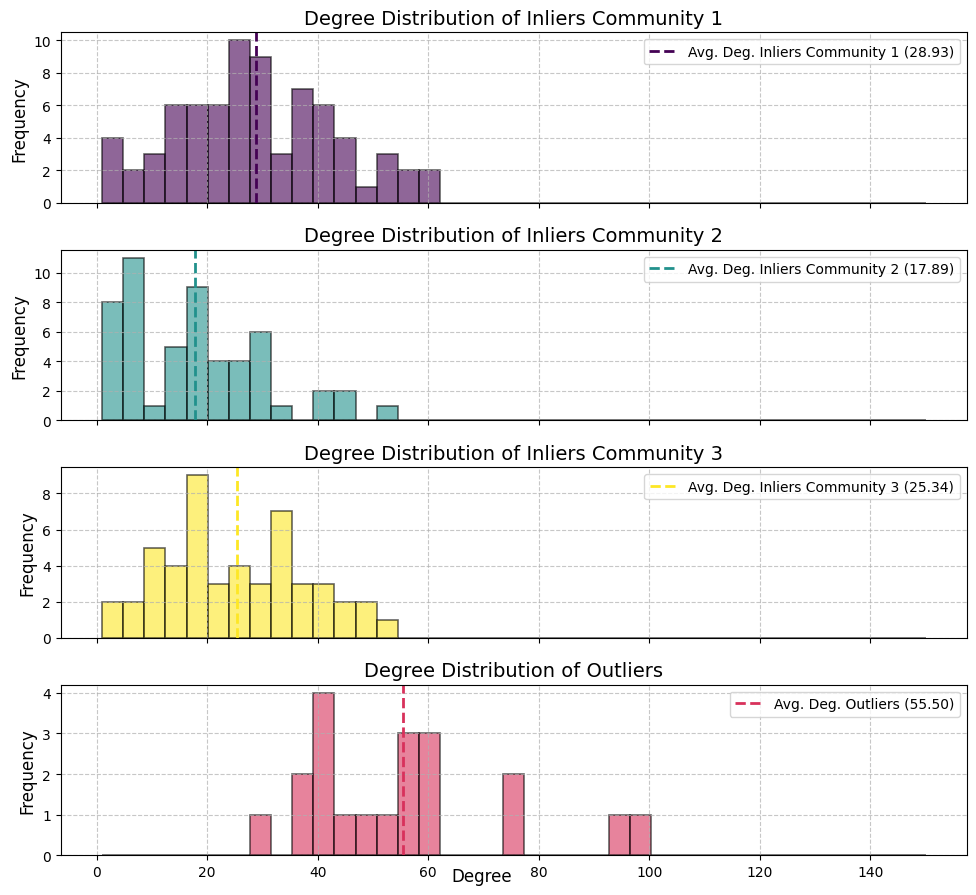

In [ ]:
sa_jazz_experiment.visualize_histogram(G_jazz, include_outliers=True)

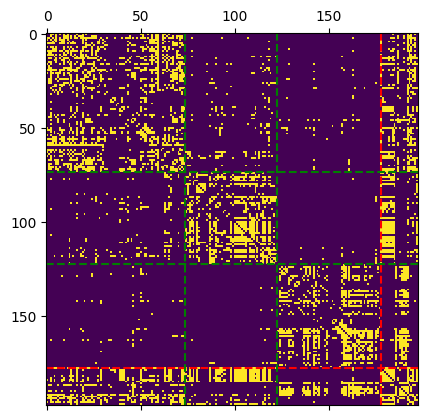

In [ ]:
# ADJACENCY MATRIX PLOT --> MOVE TO METHOD IN CLASS
solution = sa_jazz_experiment.results.solution
z_hat = sa_jazz_experiment.results.z_hat

ordered_solution = solution[np.argsort(z_hat)]
nodes_outside_solution = np.setdiff1d(np.arange(G_jazz.n), solution)
new_order = np.concatenate((ordered_solution, nodes_outside_solution))
G_ordered = G_jazz.subgraph(new_order)

n_inside = len(solution)
n_outside = len(nodes_outside_solution)
boundary_communities = np.where(np.diff(np.sort(z_hat)))[0] + 1

plt.matshow(G_ordered.A)
plt.axvline(x=n_inside - 0.5, color='red', linestyle='--')
plt.axhline(y=n_inside - 0.5, color='red', linestyle='--')
for xc in boundary_communities:
    plt.axvline(x=xc - 0.5, color='green', linestyle='--')
    plt.axhline(y=xc - 0.5, color='green', linestyle='--')

In [ ]:
sa_jazz_experiment.results.Gamma_hat

array([[0.264, 0.045, 0.014],
       [0.045, 0.331, 0.007],
       [0.014, 0.007, 0.246]])

In [ ]:
sa_jazz_experiment.results.cost

14.936076583677561

##### Spectral Clustering

In [ ]:
sc_jazz = Baseline(perturbed_graph_generator_jazz)

In [ ]:
sc_jazz.run(G_jazz)

<ipython-input-100-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


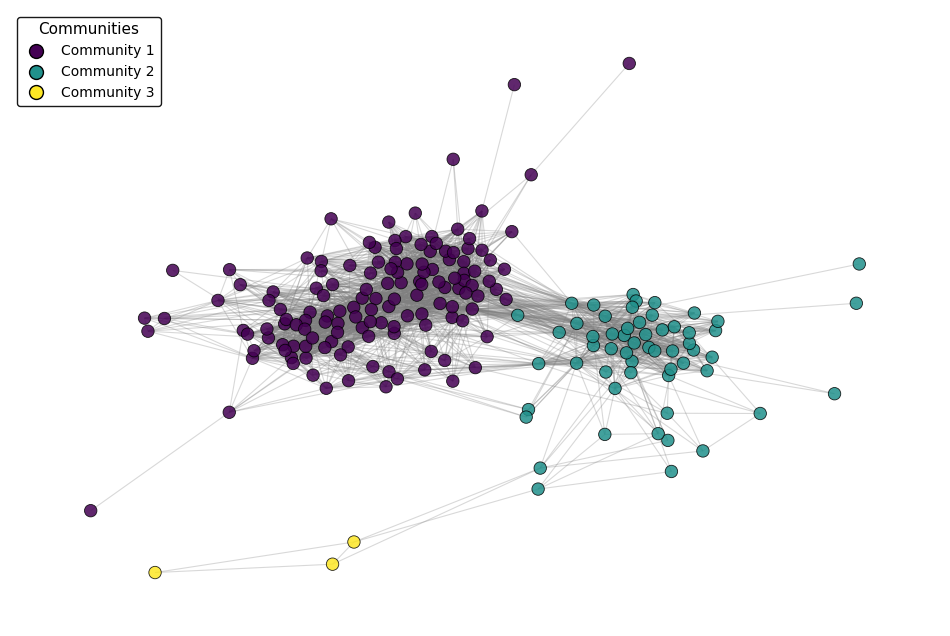

In [ ]:
sc_jazz.visualize(pos=pos_jazz)

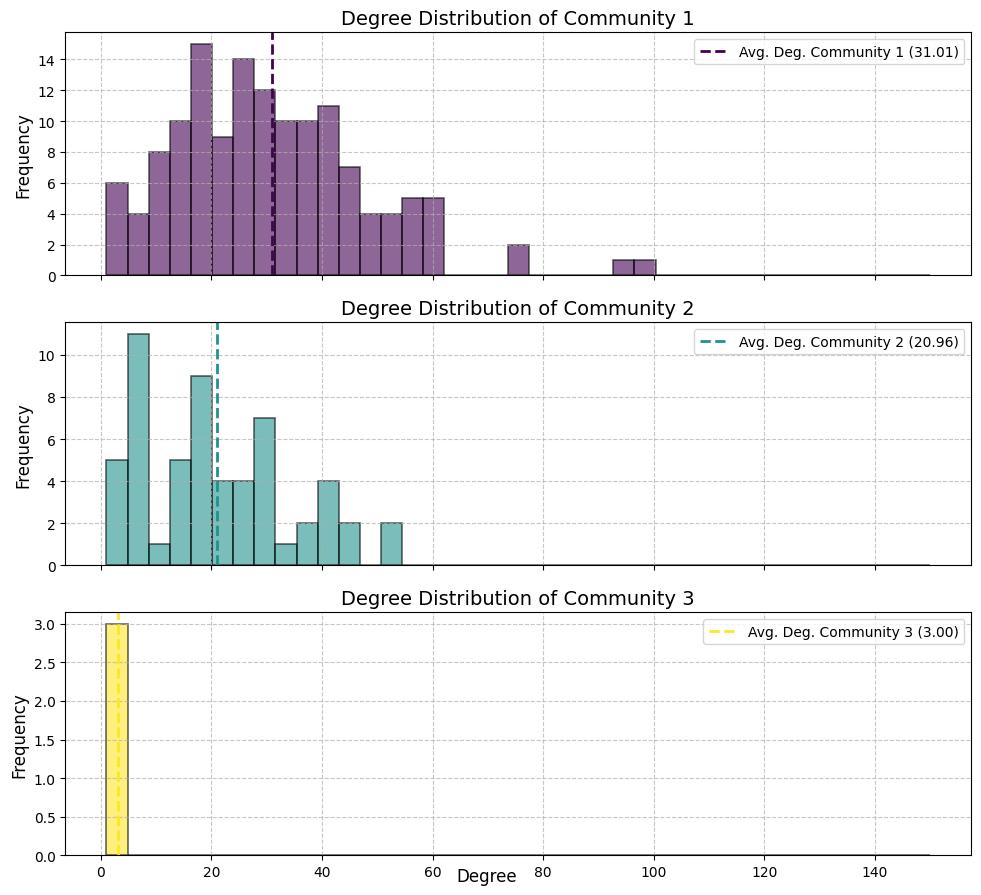

In [ ]:
sc_jazz.visualize_histogram(G_jazz)

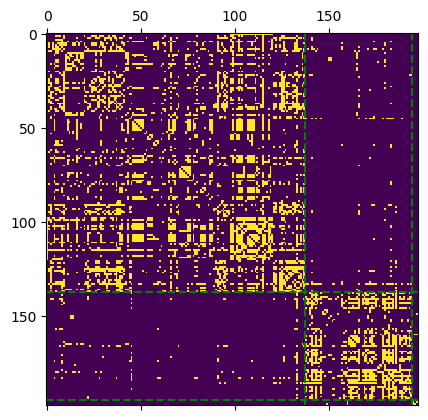

In [ ]:
z_hat_sc = sc_jazz.results.z_hat
sc_solution = np.arange(G_jazz.n)

sc_ordered_solution = sc_solution[np.argsort(z_hat_sc)]
G_ordered_sc = G_jazz.subgraph(sc_ordered_solution)

boundary_communities_sc = np.where(np.diff(np.sort(z_hat_sc)))[0] + 1

plt.matshow(G_ordered_sc.A)
for xc in boundary_communities_sc:
    plt.axvline(x=xc - 0.5, color='green', linestyle='--')
    plt.axhline(y=xc - 0.5, color='green', linestyle='--')

In [ ]:
sc_jazz.results.Gamma_hat

array([[0.217, 0.019, 0.   ],
       [0.019, 0.321, 0.018],
       [0.   , 0.018, 0.667]])

##### Pruning

In [ ]:
pruning_jazz = Pruning(
    perturbed_graph_generator_jazz,
    num_to_prune=int(gamma*G_jazz.n)
)

In [ ]:
pruning_jazz.run(G_jazz)

<ipython-input-100-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)
<ipython-input-100-e44f18e6914e>:131: RuntimeWarning: divide by zero encountered in scalar divide
  relative_l1_error = l1_error/np.sum(upper_triangular_Gamma)


In [ ]:
# It is perhaps necessary to swap assignments
community_mapping = {
    0: 1,
    1: 2,
    2: 0,
}

In [ ]:
pruning_jazz.results.z_hat = [community_mapping[i] for i in pruning_jazz.results.z_hat]

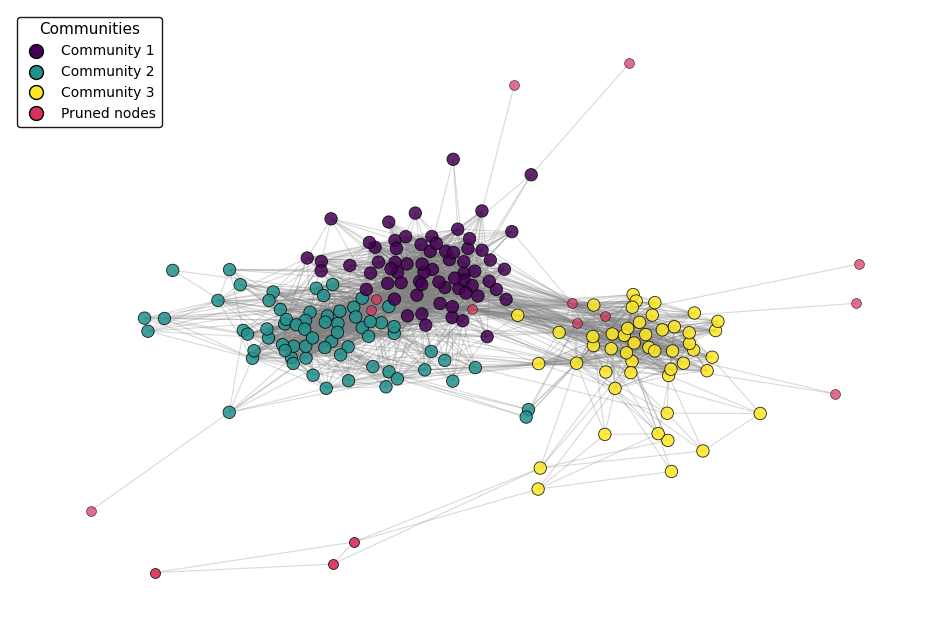

In [ ]:
pruning_jazz.visualize(G_jazz, pos=pos_jazz)

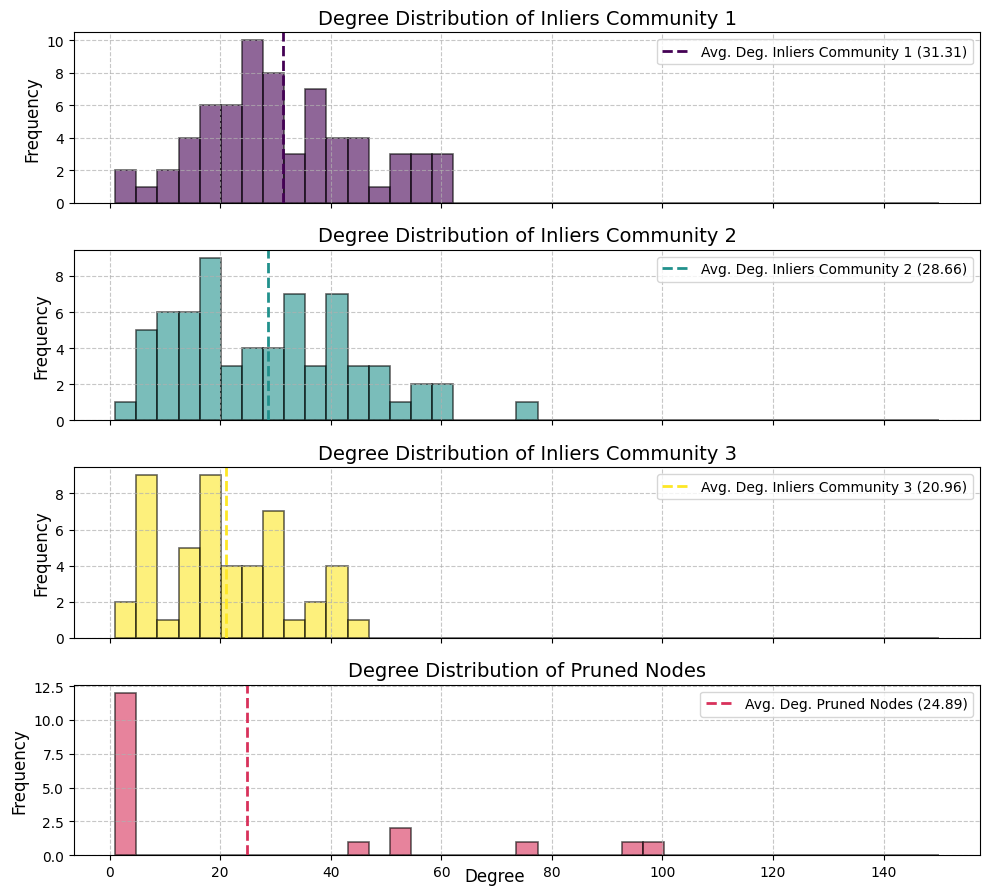

In [ ]:
pruning_jazz.visualize_histogram(G_jazz)

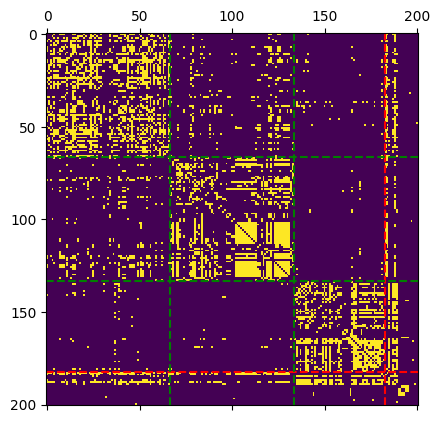

In [ ]:
# ADJACENCY MATRIX PLOT --> MOVE TO METHOD IN CLASS
solution = np.array([i for i in range(G_jazz.n)
                       if i not in pruning_jazz.removed_nodes])
z_hat = pruning_jazz.results.z_hat

ordered_solution = solution[np.argsort(z_hat)]
new_order = np.concatenate((ordered_solution, pruning_jazz.removed_nodes))
G_ordered = G_jazz.subgraph(new_order)

n_inside = len(solution)
n_outside = len(pruning_jazz.removed_nodes)
boundary_communities = np.where(np.diff(np.sort(z_hat)))[0] + 1

plt.matshow(G_ordered.A)
plt.axvline(x=n_inside - 0.5, color='red', linestyle='--')
plt.axhline(y=n_inside - 0.5, color='red', linestyle='--')
for xc in boundary_communities:
    plt.axvline(x=xc - 0.5, color='green', linestyle='--')
    plt.axhline(y=xc - 0.5, color='green', linestyle='--')

In [ ]:
pruning_jazz.results.Gamma_hat

array([[0.328, 0.008, 0.068],
       [0.008, 0.337, 0.017],
       [0.068, 0.017, 0.351]])

In [ ]:
pruning_jazz.results.cost

21.108216682348548

##### Filtering

In [ ]:
filtering_jazz = Filtering(
    perturbed_graph_generator_jazz,
    n_filtering_steps=19,
)

In [ ]:
filtering_jazz.run(G_jazz)